In [11]:
import numpy as np
from array import array
import heapq
import random
import itertools
from collections import deque, defaultdict
from scipy import sparse
from scipy.sparse.csgraph import connected_components, shortest_path

import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms.community import (
    greedy_modularity_communities,
    label_propagation_communities,
    modularity,
    kernighan_lin_bisection,
    louvain_communities,
    girvan_newman,
)
from networkx.algorithms.community.quality import modularity

from tqdm.auto import tqdm

# 1. Загальний огляд датасету

**Human gene2** - це зважена ненапрямлена мережа генів, побудована з профілів експресії генів.

* **Вузол (node)**: ген
* **Ребро (edge)** між генами (i) та (j): сильний статистичний зв’язок у даних (часто кореляційний/подібність)
* **Вага ребра (weight)**: сила зв’язку

Важливо: ребро тут зазвичай означає асоціацію, а не “причинний вплив”.

Він добре підходить під задачі семінарів, бо:

* є великі розміри (багато вузлів і зв’язків), тому видно розподіли і структури,
* мережа реальна, тож можна порівнювати з випадковим ER-графом,
* є ваги, отже можна робити розрідження та залишити лише найсильніші зв’язки.

Повна мережа дуже щільна та містить 9М ребер на 14К вузлів, тому:

* багато метрик стають “тривіальними” через дуже короткі шляхи,
* обчислення важких центральностей на повному графі можуть бути занадто дорогими,
* нам потрібен крок розрідження (sparsification), щоб отримати придатний граф.

## Початкові гіпотези

1. У мережі будуть **хаби** (деякі гени мають багато зв’язків).
2. Мережа буде **не схожа на ER** (інша кластерність, інші розподіли).
3. У мережі є **модулі/спільноти** (гени групуються).
4. Підхід розрідшення “залишимо top X% за вагою” може **розвалювати зв’язність** (буде продемоснтровано далі через GCC).
5. Після **розрідження** “скелет” мережі проявить модулі та спільноти, а хаби часто працюватимуть як мости між ними, але також зросте і **вразливість до таргетованих атак** або, інакше кажучи, чутливість сталості мережі до невипадкового видалення хабів.

## Глосарій

* (N): кількість вузлів (генів)
* (M): кількість ребер (зв’язків)
* Ступінь вузла (k_i): кількість сусідів вузла (i) (для ненапрямленого графа)
* Середній ступінь $\langle k\rangle$:
  $$
  \langle k \rangle = \frac{1}{N}\sum_{i=1}^{N} k_i = \frac{2M}{N}
  $$
* Щільність (density): частка наявних ребер від максимально можливих:
  $$
  \rho = \frac{2M}{N(N-1)}
  $$
* GCC (Giant Connected Component): частка вузлів, які лежать у найбільшій зв’язній компоненті

  * GCC fraction: $\frac{|GCC|}{N}$



In [2]:
path = "bio-human-gene2.edges"

with open(path, "rb") as f:
    head = f.read(50)
print(head)

b'%%MatrixMarket matrix coordinate real symmetric\n%-'


У файлі збережена матриця суміжності $A$ для мережі генів.

* Рядки/стовпці = гени (вузли графа)
* Елемент $A_{ij}$ = вага зв’язку між генами (i) та (j)
* Оскільки мережа ненапрямлена, то матриця симетрична $A_{ij} = A_{ji}$
* Формат `MatrixMarket coordinate` означає, що файл не зберігає всі $N^2$ значень, а лише ненульові елементи у вигляді трійок $(i, j, A_{ij})$

In [3]:
def iter_mtx_edges(path):
    """
    Стрімить з файлу трійки (i, j, w), де i,j - 0-based індекси, w - вага.
    Пропускає заголовок і коментарі.
    """
    with open(path, "r", encoding="utf-8", errors="replace") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            if s.startswith("%%MatrixMarket"):
                continue
            if s.startswith("%"):
                continue
            parts = s.split()
            if len(parts) < 3:
                continue
            try:
                i = int(parts[0]) - 1
                j = int(parts[1]) - 1
                w = float(parts[2])
            except Exception:
                continue
            yield i, j, w

Тут ми:

* рахуємо максимальний індекс, щоб визначити N
* рахуємо скільки є діагональних записів (i=j)
* рахуємо, скільки записів у верхньому трикутнику (i<j) та нижньому (i>j), щоб зрозуміти, як збережена симетрія
* беремо вибірку ваг (щоб не тримати все) і оцінюємо min/median/max приблизно

In [4]:
def overview_full_dataset(path, sample_size=300_000, seed=0):
    rng = np.random.default_rng(seed)
    sample = []

    max_idx = -1
    n_diag = 0
    n_upper = 0
    n_lower = 0
    n_total = 0

    for i, j, w in iter_mtx_edges(path):
        n_total += 1
        max_idx = max(max_idx, i, j)

        if i == j:
            n_diag += 1
        elif i < j:
            n_upper += 1
        else:
            n_lower += 1

        if len(sample) < sample_size:
            sample.append(w)
        else:
            r = rng.integers(0, n_total)
            if r < sample_size:
                sample[r] = w

    N = max_idx + 1
    sample = np.array(sample, dtype=np.float32)

    info = {
        "N_inferred": int(N),
        "n_total_lines": int(n_total),
        "n_diagonal": int(n_diag),
        "n_upper(i<j)": int(n_upper),
        "n_lower(i>j)": int(n_lower),
        "weight_sample_min": float(sample.min()) if sample.size else None,
        "weight_sample_median": float(np.median(sample)) if sample.size else None,
        "weight_sample_max": float(sample.max()) if sample.size else None,
    }
    return info

In [ ]:
info = overview_full_dataset(path)
info

{'N_inferred': 14340,
 'n_total_lines': 9041364,
 'n_diagonal': 14340,
 'n_upper(i<j)': 0,
 'n_lower(i>j)': 9027024,
 'weight_sample_min': 0.03004900924861431,
 'weight_sample_median': 0.038211122155189514,
 'weight_sample_max': 1.0}

У мережі з випадковою підвибіркою ваг (300k значень) загалом збережено 14 340 генів (вузлів).

* Діагональ $A_{ii}$ присутня і має 14 340 записів, тобто у файлі є рядки типу `i i 1` (самозв’язок). Для аналізу мережі ми приберемо діагональ, бо self-loop майже завжди не використовують у стандартних метриках.
* Файл зберігає тільки нижній трикутник матриці (де $i>j$) тобто половину симетричної матриці, де кожен запис $i>j$ — це одне унікальне ненапрямлене ребро. Щоб зробити повну матрицю суміжності, ми при побудові графа додамо і ($i,j$), і ($j,i$).
* Типова вага дуже мала (медіана ~0.038 близька до мінімуму ~0.03), але є рідкісні дуже сильні зв’язки (до 1.0). Розподіл ваг, найімовірніше, буде містити важкий хвіст: багато слабких зв’язків, мало сильних.
* Через домінування слабких зв’язків просте глобальне порогування по значення ваги для розрідження може суттєво змінювати зв’язність мережі (підтвердимо це, якщо GCC при збільшенні top-q% буде зростати повільно).

# 2. Побудова розрідженого графа, придатного для подальших метрик

**GCC fraction** у цьому випадку буде ключовим критерієм при зменшенні зв'язків і вибору оптимального розміру кінцевої вибірки, тому що метрики відстаней на кшталт середньої довжини найкоротшого шляху $\langle l\rangle$, максимального шляху $l_{max}$ або розподілу $P(l)$ мають зміст лише тоді, коли між вузлами існують шляхи. Якщо граф розпадається на багато компонент, то для великої частини пар вузлів шлях не існує, а метрики втрачають репрезентативність.

У моделях поширення (наприклад, SIR) або в аналізі робастності (видалення вузлів) нас цікавить, чи залишається велика зв’язна частина мережі. Це також майже завжди зводиться до поведінки GCC.

Ми хочемо робити висновки про мережу, а не про маленькі шматочки. Якщо GCC fraction = 0.3, то будь-які висновки про шляхи/процеси стосуються лише ~30% генів. Тому практична ціль на цьому етапі отримати високу GCC fraction (наприклад, ≥ 0.85).

## 2.2. Експеримент 1: просте top-q% порогування за вагою

Природний “наївний” спосіб розрідження через відсіювання усіх ребер поза top-q% за вагою.

**Очікувана проблема:** у кореляційних/подібнісних мережах часто буває так, що містки між групами (хабами) мають не найбільші ваги.
Тому коли ми залишаємо тільки верхівку за вагою, мережа розсипається на компоненти.

In [7]:
def mtx_iter_entries(path):
    with open(path, "r", encoding="utf-8", errors="replace") as f:
        header = f.readline().strip()
        if not header.startswith("%%MatrixMarket"):
            raise ValueError("Not a MatrixMarket file")

        line = f.readline()
        while line and line.lstrip().startswith("%"):
            line = f.readline()

        # пропускаємо порожні
        while line and not line.strip():
            line = f.readline()

        n_rows, n_cols, nnz = map(int, line.strip().split())
        yield ("__shape__", n_rows, n_cols, nnz)

        for line in f:
            if not line.strip() or line.lstrip().startswith("%"):
                continue
            i, j, v = line.split()[:3]
            yield (int(i) - 1, int(j) - 1, float(v))

def estimate_threshold_top_frac(path, top_frac=0.01, sample_size=500_000, seed=0):
    rng = np.random.default_rng(seed)
    sample = np.empty(sample_size, dtype=np.float32)
    filled = 0
    seen = 0

    it = mtx_iter_entries(path)
    tag = next(it)  # ('__shape__', n, n, nnz)

    for i, j, w in it:
        if i == j:
            continue
        seen += 1
        w = np.float32(w)

        if filled < sample_size:
            sample[filled] = w
            filled += 1
        else:
            r = rng.integers(0, seen)
            if r < sample_size:
                sample[r] = w

    sample = sample[:filled]
    thr = np.quantile(sample, 1.0 - top_frac, method="higher")
    return float(thr)

def build_sparse_graph_threshold_robust(path, threshold, drop_diagonal=True):
    thr = float(threshold)

    rows = array("I")
    cols = array("I")
    data = array("f")

    max_idx = -1
    started = False  # щоб пропустити заголовок/коментарі

    with open(path, "r", encoding="utf-8", errors="replace") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue

            # пропускаємо заголовок і коментарі
            if s.startswith("%%MatrixMarket"):
                continue
            if s.startswith("%"):
                continue

            # тепер очікуємо або size-line, або edge-line
            parts = s.split()
            if len(parts) < 3:
                continue

            # намагаємося інтерпретувати як "i j w"
            try:
                i = int(parts[0]) - 1
                j = int(parts[1]) - 1
                w = float(parts[2])
            except Exception:
                continue

            started = True

            if drop_diagonal and i == j:
                max_idx = max(max_idx, i, j)
                continue

            max_idx = max(max_idx, i, j)

            if w < thr:
                continue

            # додаємо обидва напрямки (ненапрямлений граф)
            rows.append(i); cols.append(j); data.append(np.float32(w))
            rows.append(j); cols.append(i); data.append(np.float32(w))

    if not started:
        raise ValueError("No numeric edge lines were parsed. Check file format/path.")

    N = max_idx + 1
    A = sparse.coo_matrix(
        (np.frombuffer(data, dtype=np.float32),
         (np.frombuffer(rows, dtype=np.uint32), np.frombuffer(cols, dtype=np.uint32))),
        shape=(N, N)
    ).tocsr()

    A.setdiag(0)
    A.eliminate_zeros()
    return A

In [8]:
def gcc_fraction_from_csr(A):
    n_comp, labels = connected_components(A, directed=False, return_labels=True)
    gcc = int(np.bincount(labels).max())
    return gcc / A.shape[0], n_comp

def topq_experiment(path, fracs=(0.005, 0.01, 0.02, 0.03, 0.05, 0.1)):
    rows = []
    for f in fracs:
        thr = estimate_threshold_top_frac(path, top_frac=f)
        A = build_sparse_graph_threshold_robust(path, threshold=thr)

        N = A.shape[0]
        M = A.nnz // 2
        avg_k = 2*M / N

        gcc_frac, n_comp = gcc_fraction_from_csr(A)
        rows.append((f, thr, M, avg_k, n_comp, gcc_frac))

        print(f"top={f:.3f} thr={thr:.5f} M={M} <k>={avg_k:.2f} comps={n_comp} GCC={gcc_frac:.3f}")

    return rows

In [ ]:
rows = topq_experiment(path)

top=0.005 thr=0.09486 M=44274 <k>=6.17 comps=10842 GCC=0.231
top=0.010 thr=0.08547 M=87807 <k>=12.25 comps=9650 GCC=0.316
top=0.020 thr=0.07650 M=178013 <k>=24.83 comps=8320 GCC=0.411
top=0.030 thr=0.07150 M=267099 <k>=37.25 comps=7463 GCC=0.473
top=0.050 thr=0.06529 M=446858 <k>=62.32 comps=6272 GCC=0.556
top=0.100 thr=0.05696 M=898900 <k>=125.37 comps=4623 GCC=0.674


Із ростом `top` мережа стає щільнішою: (M) і $\langle k\rangle$ швидко зростають (наприклад, від $\langle k\rangle\approx 6.17$ при `top=0.005` до $\langle k\rangle\approx 125.37$ при `top=0.10`). Але при цьому зв’язність відновлюється повільно:
  * **GCC** зростає лише від 0.231 до 0.674 навіть при `top=0.10`.
  * кількість компонент **comps** залишається дуже великою (від ~10k до ~4.6k).

Гіпотеза підтвердилась, просте **top-q%** порогування за вагою робить мережу сильно фрагментованою, тому такий граф незручний для подальших задач.

## 2.1 Експеримент 2: kNN-розрідження

**Проблема top-q%**, що воно “рівняє” всі вузли під один глобальний поріг.
Але в реальних біологічних даних для частини генів зв’язки слабші за шкалою (але важливі відносно інших їхніх зв’язків), і якщо глобально відсікти все “нижче порогу”, то такі гени стають ізольованими або потрапляють у дрібні компоненти.

**kNN-розрідження** робить більш справедливу річ:

* кожен ген зберігає **k найсильніших сусідів**,
* ми гарантуємо, що в кожного вузла є хоча б кілька ребер,
* це часто значно підвищує GCC fraction при помірному числі ребер.

In [6]:
def infer_N_from_file(path):
    max_idx = -1
    for i, j, w in iter_mtx_edges(path):
        max_idx = max(max_idx, i, j)
    return max_idx + 1

def build_knn_edges(path, N, k=20, ignore_diagonal=True):
    heaps = [ [] for _ in range(N) ]  # min-heap: (w, nbr)

    # беремо нижній трикутник
    for i, j, w in iter_mtx_edges(path):
        if ignore_diagonal and i == j:
            continue
        if not (i > j):
            continue

        # оновлюємо для i
        hi = heaps[i]
        if len(hi) < k:
            heapq.heappush(hi, (w, j))
        else:
            if w > hi[0][0]:
                heapq.heapreplace(hi, (w, j))

        # оновлюємо для j
        hj = heaps[j]
        if len(hj) < k:
            heapq.heappush(hj, (w, i))
        else:
            if w > hj[0][0]:
                heapq.heapreplace(hj, (w, i))

    # унікальні ненапрямлені ребра
    edges = {}
    for u in range(N):
        for w, v in heaps[u]:
            a, b = (u, v) if u < v else (v, u)
            if (a, b) not in edges or w > edges[(a, b)]:
                edges[(a, b)] = w

    return [(a, b, w) for (a, b), w in edges.items()]

def edges_to_csr(N, edges):
    rows, cols, data = [], [], []
    for u, v, w in edges:
        rows.extend([u, v])
        cols.extend([v, u])
        data.extend([w, w])
    A = sparse.coo_matrix((data, (rows, cols)), shape=(N, N)).tocsr()
    A.setdiag(0)
    A.eliminate_zeros()
    return A

def basic_stats_knn(A):
    N = A.shape[0]
    M = A.nnz // 2
    deg = np.diff(A.indptr)
    n_comp, labels = connected_components(A, directed=False, return_labels=True)
    gcc = int(np.bincount(labels).max())
    gcc_frac = gcc / N if N else 0.0
    avg_k = 2 * M / N if N else 0.0

    return {
        "N": int(N),
        "M": int(M),
        "avg_degree": float(deg.mean()),
        "<k>": float(avg_k),
        "kmax": int(deg.max()) if N else 0,
        "comps": int(n_comp),
        "GCC": float(gcc_frac),
    }

In [ ]:
N = 14340  # знаємо з EDA

for k in [5, 10, 15, 20, 30, 50]:
    edges = build_knn_edges(path, N=N, k=k)
    A_knn = edges_to_csr(N, edges)
    s = basic_stats_knn(A_knn)
    summary = (f"N={s['N']} M={s['M']} avg_degree={s['avg_degree']:.2f} <k>={s['<k>']:.2f} "
               f"kmax={s['kmax']} comps={s['comps']} GCC={s['GCC']:.3f}")
    print(f"k={k}", summary)

k=5 N=14340 M=65761 avg_degree=9.17 <k>=9.17 kmax=1282 comps=321 GCC=0.977
k=10 N=14340 M=128851 avg_degree=17.97 <k>=17.97 kmax=1706 comps=320 GCC=0.978
k=15 N=14340 M=190332 avg_degree=26.55 <k>=26.55 kmax=2097 comps=320 GCC=0.978
k=20 N=14340 M=250565 avg_degree=34.95 <k>=34.95 kmax=2446 comps=320 GCC=0.978
k=30 N=14340 M=368180 avg_degree=51.35 <k>=51.35 kmax=2957 comps=320 GCC=0.978
k=50 N=14340 M=593874 avg_degree=82.83 <k>=82.83 kmax=3599 comps=320 GCC=0.978


Уже при `k=5` отримуємо: **GCC** ≈ 0.977, тобто ~97.7% генів у найбільшій зв’язній компоненті, **comps** ≈ 321, набагато менше компонент, ніж у top-q%.

При збільшенні `k` GCC майже не змінюється (≈0.978), а $\langle k\rangle$ росте (від ~9.17 до ~82.83), тобто граф стає дедалі щільнішим, але зв’язність уже “досягнута” майже з самого початку.

kNN підходить краще, бо він вирівнює локальну ситуацію для кожного вузла. Кожен ген зберігає свої найсильніші зв’язки, тому вузли рідше стають ізольованими, і мережа краще зв'язується в одну велику компоненту, що критично, бо більшість аналізів (шляхи, поширення, атаки) мають сенс саме на великій зв’язній частині мережі.

## Фінальний розріджений граф

Візуалізуємо

In [11]:
def visualize_sample_from_gcc(A_gcc, sample_n=500, seed=0, ax=None, title=None):
    rng = np.random.default_rng(seed)
    n = A_gcc.shape[0]
    sample_n = min(sample_n, n)

    # випадкові вузли з GCC і індукований підграф
    idx = np.sort(rng.choice(n, size=sample_n, replace=False))
    A_sub = A_gcc[idx][:, idx]

    G = nx.from_scipy_sparse_array(A_sub)

    pos = nx.spring_layout(G, seed=seed, k=None)

    if ax is None:
        plt.figure(figsize=(8, 8))
        ax = plt.gca()

    nx.draw_networkx_nodes(G, pos, node_size=8, ax=ax)
    nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.4, ax=ax)

    ax.set_axis_off()
    ax.set_title(title or f"n={sample_n}")

k=10  N=14340  M=128851  GCC size=14020  GCC fraction=0.978  comps=320
k=15  N=14340  M=190332  GCC size=14020  GCC fraction=0.978  comps=320
k=20  N=14340  M=250565  GCC size=14020  GCC fraction=0.978  comps=320


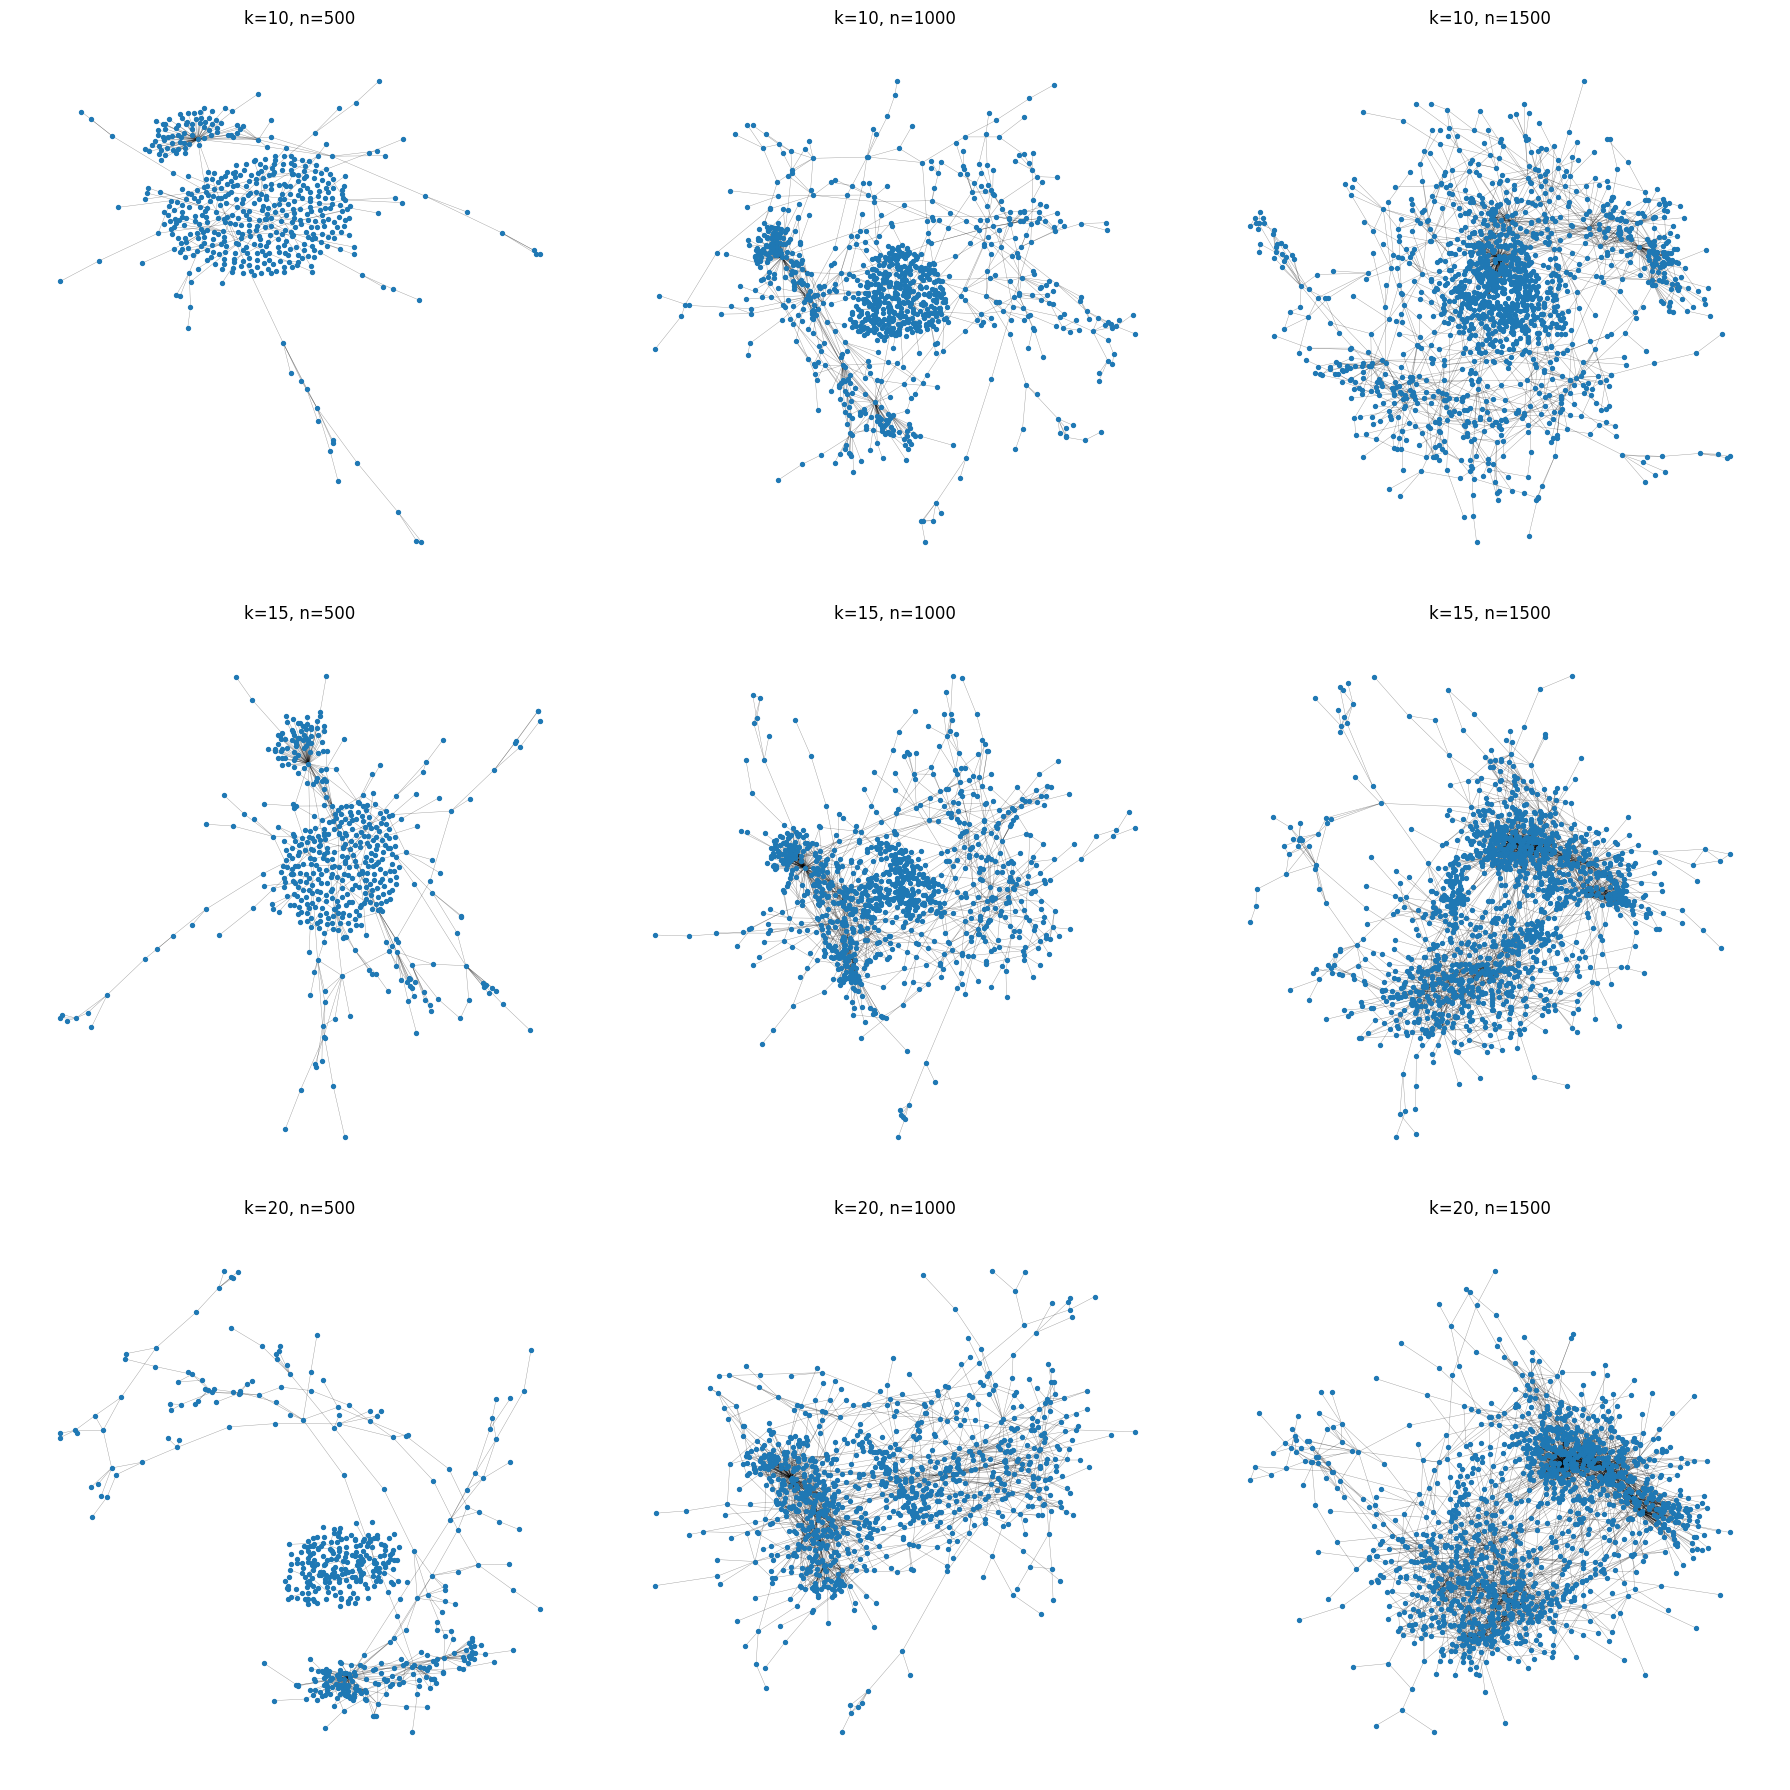

In [ ]:
N = 14340
k_list = [10, 15, 20]
sample_list = [500, 1000, 1500]

fig, axes = plt.subplots(nrows=len(k_list), ncols=len(sample_list), figsize=(18, 18))

for r, k_final in enumerate(k_list):
    edges = build_knn_edges(path, N=N, k=k_final)
    A = edges_to_csr(N, edges)

    n_comp, labels = connected_components(A, directed=False, return_labels=True)
    sizes = np.bincount(labels)
    gcc_label = sizes.argmax()
    gcc_nodes = np.where(labels == gcc_label)[0]
    A_gcc = A[gcc_nodes][:, gcc_nodes]

    print(f"k={k_final}  N={A.shape[0]}  M={A.nnz//2}  "
          f"GCC size={A_gcc.shape[0]}  GCC fraction={A_gcc.shape[0]/A.shape[0]:.3f}  comps={n_comp}")

    for c, sample_n in enumerate(sample_list):
        ax = axes[r, c]
        visualize_sample_from_gcc(
            A_gcc,
            sample_n=sample_n,
            seed=42,
            ax=ax,
            title=f"k={k_final}, n={sample_n}"
        )

plt.tight_layout()
plt.show()

Цікаво що для всіх 3 випадків всі гени (всі вузли, які є в датасеті) **N = 14340**, у найбільшій зв’язній компоненті **GCC size = 14020**, отже **14340 − 14020 = 320 вузлів** поза GCC, що рівне **comps = 320**. Тобто поза GCC майже кожен із цих 320 вузлів є окремою компонентою розміру 1 (ізольованим вузлом).

kNN добре “зшив” майже всю мережу (97.8% генів), але є невелика група генів, які мають дуже слабкі зв’язки з іншими, або їхні найсильніші зв’язки теж ведуть у маленькі групи/не взаємні, і в підсумку вони лишились без зв’язків у побудованому графі.


**Виібр фінального k:**

Візьмемо **k = 15** як компроміс для обрахунку основних метрик. GCC майже максимальна вже з k=5 і максимальна з k=10, але k=15 дає трохи щільніший граф, стабільніший для центральностей і спільнот.

In [ ]:
# Фінальний параметр розрідження (kNN)
K_SPARSE = 15

# Побудова робочого kNN-графа
N = 14340
edges = build_knn_edges(path, N=N, k=K_SPARSE)
A_work = edges_to_csr(N, edges)

print(f"Working graph ready: k={K_SPARSE}, N={A_work.shape[0]}, M={A_work.nnz//2}")

# Побудова підграфа тільки найбільшої зв’язної компоненти
n_comp, labels = connected_components(A_work, directed=False, return_labels=True)
sizes = np.bincount(labels)
gcc_label = sizes.argmax()
gcc_nodes = np.where(labels == gcc_label)[0]

A_gcc = A_work[gcc_nodes][:, gcc_nodes]

print(f"GCC ready: N={A_gcc.shape[0]}, M={A_gcc.nnz//2}, fraction={A_gcc.shape[0]/A_work.shape[0]:.3f}, comps={n_comp}")

Working graph ready: k=15, N=14340, M=190332
GCC ready: N=14020, M=190331, fraction=0.978, comps=320


**`A_work`**

Це весь робочий граф після розрідження kNN (k=15) на всіх вузлах датасету:

* розмір: $14340 \times 14340$
* містить усі компоненти: одну велику + дрібні + можливі ізольовані вузли
* зручно для метрик, які не потребують, щоб між усіма вузлами існували шляхи:
  * $N, M, \langle k\rangle, k_{max}$
  * розподіл ступеня (P(k))
  * локальна кластерність $C$ (і її розподіл $P(C)$)

**`A_gcc`**

Це підграф тільки найбільшої зв’язної компоненти:

* розмір: $14020 \times 14020$
* всередині GCC між будь-якими двома вузлами є шлях
* потрібен для метрик, які залежать від найкоротших шляхів і “глобальної зв’язності”:

  * середня довжина шляху $\langle l\rangle$
  * максимальна довжина найкоротшого шляху $l_{max}$
  * розподіл $P(l)$
  * процеси поширення і робастність при атаках



# Практична робота: Частина 1

## Завдання
На побудованому раніше робочому розрідженому графі для заданого датасету (мережа генів) обчислити основні характеристики мережі:

$N,; M,; \langle k\rangle,; k_{\max},; \langle l\rangle,; l_{\max},; GCC,; C,; \text{centralities}$

Після цього порівняти ці характеристики з класичним випадковим графом Ердоша–Реньї, що має співставний розмір і густину.

## Хід роботи

**Основні індекси мережі та їх обчислення:**

Далі всі метрики ми рахуємо для робочого графа $G=(V,E)$, де:

* $V$ – множина вузлів
* $E$ – множина ребер

1. Кількість вузлів $N = |V|$ - кількість генів, які присутні у графі
2. Кількість ребер  $M = |E|$ – це кількість унікальних ребер (ненапрялений граф)
3. Ступінь вузла $k_i$ – кількість сусідів вузла $i$
4. Середній ступінь вузлів $\langle k\rangle = \frac{1}{N}\sum_{i=1}^{N} k_i$, де для ненапрямленого графа справедливо $\sum_{i=1}^{N} k_i = 2M \Rightarrow \langle k\rangle = \frac{2M}{N}$
5. Максимальний ступінь вузлів $k_{\max} = \max_i k_i$

Для GCC (Giant Connected Component) - найбільшої зв’язної компоненти (підмножина вузлів, всередині якої між будь-якими двома вузлами існує шлях) графа фіксуємо кількість компонент $n_{\text{comp}}$, розмір GCC $|GCC|$ та частку вузлів у GCC (GCC fraction) $\text{GCC}_{\text{frac}}=\frac{|GCC|}{N}$.

Метрики, пов’язані з найкоротшими шляхами, мають сенс лише там, де вузли взаємно досяжні, тому $\langle l\rangle$ і $l_{\max}$ ми рахуємо саме на GCC.

Нехай $(d(u,v)$ – довжина найкоротшого шляху між вузлами $u$ і $v$ (у цій частині роботи за кількістю ребер без урахування ваг):

6. Середня довжина найкоротшого шляху $\langle l\rangle = \frac{1}{|\text{Pairs}|}\sum_{u\neq v \in GCC} d(u,v)$, де $|\text{Pairs}| = |GCC|\cdot(|GCC|-1)$ (якщо рахувати впорядковані пари) або $\frac{|GCC|(|GCC|-1)}{2}$(невпорядковані). У реалізації рахуємо відстані від кожної вершини до всіх інших (впорядковані пари), але середнє $\langle l\rangle$ еквівалентне невпорядкованому випадку для ненапрямленого графа
7. Максимальна довжина найкоротшого шляху $l_{\max} = \max_{u,v\in GCC} d(u,v)$ обчислюється BFS (пошук у ширину) без урахування ваг

**Кластеризація (C):**

Відображає, наскільки часто "сусіди вузла теж з’єднані між собою", тобто наскільки мережа "трикутна":

1. Локальна кластеризація вузла $C_i = \frac{2T_i}{k_i(k_i-1)}$ для вузла $i$ зі ступенем $k_i\ge 2$, де $T_i$ – кількість трикутників, що проходять через вузол $i$
2. Глобальна кластеризація (transitivity) $C = \frac{3 \cdot \text{Triangles}}{\text{Triplets}}$, де $\text{Triangles}$ – кількість трикутників у графі, $\text{Triplets} = \sum_i \binom{k_i}{2}$ – кількість зв’язаних трійок (дві вершини, приєднані до однієї). Тут $\text{Triangles}$ рахуємо через матрицю суміжності $A$ (бінарну, без діагоналі) $\text{Triangles}=\frac{1}{6}\sum_{i,j}\bigl((A^2)\odot A\bigr)*{ij}$, де $A*{ij}=1$, якщо між $i$ та $j$ є ребро, $A^2=A\cdot A$ (матриця, елемент $(A^2)_{ij}$ дає кількість шляхів довжини 2 між $i$ та $j$), а $\odot$ – Адамарів добуток (поелементне множення). Ділення на 6 враховує, що кожен трикутник у ненапрямленому графі підраховується 6 разів


**Центральності (centralities):**

Показують, "наскільки важливий" вузол у мережі. Ми розраховуємо (на GCC):

1. Degree centrality $C_D(i)=\frac{k_i}{N-1}$ - скільки прямих з'єднань має вузол (простий, локальний вигляд)
2. Closeness centrality $C_C(i) = \frac{N-1}{\sum_{j\neq i} d(i,j)}$ - як близько знаходиться вузол до всіх інших вузлів
3. PageRank $PR(i)=\frac{1-\alpha}{N}+\alpha\sum_{j\in \mathcal{N}(i)} \frac{PR(j)}{k_j}$, де $\alpha$ – коефіцієнт затухання (типово 0.85), $\mathcal{N}(i)$ – сусіди вузла $i$. Ітераційна міра "важливості" вузлів, що вимірюється на основі важливості сусідів вузла (рекурсивний вплив)
4. Eigenvector centrality $x_i = \frac{1}{\lambda}\sum_j A_{ij}x_j$ або у векторній формі $A\mathbf{x}=\lambda \mathbf{x}$ - те ж визначення через важливість сусідів на основі компоненти головного власного вектора

**Порівняння з графом Ердоша–Реньї (ER):**

ER-граф $G(N,p)$ - це "випадкова базова модель", що будується через з’єднання кожної пари вузлів $N(N−1)$ (невпорядковані пари без $(u,u)$ у нашому випадку) ребром з імовірністю $p$. Щоб ER був "співставний" із нашим графом, беремо той самий $N$ кількість вузлів і підбираємо $p$ так, щоб очікувана кількість ребер була близькою до нашої $\mathbb{E}[M_{ER}] = p\cdot \frac{N(N-1)}{2} \approx M$. Звідси $p = \frac{2M}{N(N-1)}$ фактично є густиною графа.

Порівнюємо ті самі метрики:

* $N, M, \langle k\rangle, k_{max}$
* GCC fraction, кількість компонент
* $\langle l\rangle, l_{\max}$ (на GCC)
* кластеризацію $C$
* центральності


In [8]:
def basic_stats(A):
    # Базові характеристики для CSR-матриці суміжності (ненапрямлений граф)
    N = A.shape[0]
    M = A.nnz // 2
    avg_k = 2 * M / N if N else 0.0
    deg = np.diff(A.indptr)
    kmax = int(deg.max()) if N else 0
    density = (2*M) / (N*(N-1)) if N > 1 else 0.0
    return {"N": int(N), "M": int(M), "<k>": float(avg_k), "kmax": kmax, "density": float(density)}

def extract_gcc(A):
    # Повертає підграф GCC + індекси вузлів GCC + кількість компонент
    n_comp, labels = connected_components(A, directed=False, return_labels=True)
    sizes = np.bincount(labels)
    gcc_label = sizes.argmax()
    gcc_nodes = np.where(labels == gcc_label)[0]
    A_gcc = A[gcc_nodes][:, gcc_nodes]
    gcc_frac = A_gcc.shape[0] / A.shape[0] if A.shape[0] else 0.0
    return A_gcc, gcc_nodes, float(gcc_frac), int(n_comp)

def exact_path_stats_unweighted(A_gcc, show_progress=True):
    # Точні <l> - середня довжина найкоротшого шляху (по парах)
    # та l_max - максимальна довжина найкоротшого шляху (діаметр) на GCC (BFS з кожної вершини)
    n = A_gcc.shape[0]
    indptr = A_gcc.indptr
    indices = A_gcc.indices

    total_dist = 0
    total_pairs = 0
    global_max = 0

    iterator = range(n)
    if show_progress:
        iterator = tqdm(iterator, total=n, desc="Exact BFS over GCC")

    for s in iterator:
        # BFS
        dist = np.full(n, -1, dtype=np.int32)
        dist[s] = 0
        q = deque([s])

        while q:
            v = q.popleft()
            start, end = indptr[v], indptr[v+1]
            neigh = indices[start:end]
            for u in neigh:
                if dist[u] == -1:
                    dist[u] = dist[v] + 1
                    q.append(u)

        # У GCC всі повинні бути досяжні (без -1), але про всяк випадок >0 прибирає self=0
        reachable = dist[dist > 0]
        if reachable.size:
            total_dist += int(reachable.sum())
            total_pairs += int(reachable.size)
            local_max = int(reachable.max())
            if local_max > global_max:
                global_max = local_max

    avg_l = total_dist / total_pairs if total_pairs else np.nan
    return {"<l>": float(avg_l), "l_max": int(global_max), "pairs": int(total_pairs)}

def global_clustering_transitivity(A):
    # Точний глобальний коефіцієнт кластеризації (transitivity)
    # Triangles = sum((A^2 ⊙ A)) / 6
    # Triplets  = sum_i k_i*(k_i-1)/2
    # C_global  = 3*Triangles / Triplets

    # робимо бінарну матрицю (0/1), діагональ прибираємо
    A_bin = A.copy()
    A_bin.data = np.ones_like(A_bin.data)
    A_bin.setdiag(0)
    A_bin.eliminate_zeros()

    deg = np.diff(A_bin.indptr)
    triplets = np.sum(deg * (deg - 1) // 2)

    # A2 = A*A
    A2 = A_bin @ A_bin
    # sum(A2_ij * A_ij) = 6 * triangles
    tri6 = A2.multiply(A_bin).sum()
    triangles = tri6 / 6.0

    Cg = (3.0 * triangles / triplets) if triplets > 0 else np.nan
    return {"C_global": float(Cg), "triangles": float(triangles), "triplets": int(triplets)}

def closeness_approx_from_sources(G, sources=50, seed=0):
    # обираємо 'sources' вузлів, рахуємо BFS від кожного source, для кожного вузла v: avg_dist_to_sources(v) -> closeness ~ 1/avg_dist

    rng = random.Random(seed)
    nodes = list(G.nodes())
    n = len(nodes)
    s = min(int(sources), n)
    src = rng.sample(nodes, s)

    # накопичуємо суму дистанцій до джерел
    dist_sum = {v: 0.0 for v in nodes}
    reach_cnt = {v: 0 for v in nodes}

    for s_node in src:
        # BFS distances from s_node
        d = nx.single_source_shortest_path_length(G, s_node)
        for v, dv in d.items():
            if v == s_node:
                continue
            dist_sum[v] += dv
            reach_cnt[v] += 1

    # оцінка closeness
    clos = {}
    for v in nodes:
        if reach_cnt[v] == 0:
            clos[v] = 0.0
        else:
            avg_d = dist_sum[v] / reach_cnt[v]
            clos[v] = 1.0 / avg_d if avg_d > 0 else 0.0
    return clos

def centralities_report(G, seed=0, betweenness_mode="approx", k_approx=200, closeness_mode="approx", closeness_sources=50):
    # Центральності

    # degree (точно)
    deg_cent = nx.degree_centrality(G)

    # closeness (точно)
    if closeness_mode == "exact":
        closeness = nx.closeness_centrality(G)
        closeness_key = "closeness"
    else:
        closeness = closeness_approx_from_sources(G, sources=closeness_sources, seed=seed)
        closeness_key = f"closeness_approx(sources={min(closeness_sources, G.number_of_nodes())})"

    # PageRank (ітераційно)
    pr = nx.pagerank(G, alpha=0.85, weight=None)

    # Eigenvector (ітераційно)
    ev = nx.eigenvector_centrality(G, max_iter=500, tol=1e-6, weight=None)

    # Betweenness
    if betweenness_mode == "exact":
        btw = nx.betweenness_centrality(G, normalized=True, weight=None)
        key = "betweenness"
    else:
        btw = nx.betweenness_centrality(G, k=k_approx, seed=seed, normalized=True, weight=None)
        key = f"betweenness_approx(k={k_approx})"

    return {
        "degree": deg_cent,
        "closeness": closeness,
        "pagerank": pr,
        "eigenvector": ev,
        key: btw
    }

def top_items(d, top=10):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:top]

def build_er_graph_like(A_work, seed=42):
    # ER граф для порівняння
    s = basic_stats(A_work)
    N = s["N"]
    p = s["density"]
    G_er = nx.erdos_renyi_graph(n=N, p=p, seed=seed, directed=False)
    A_er = nx.to_scipy_sparse_array(G_er, format="csr")
    A_er.setdiag(0)
    A_er.eliminate_zeros()
    return A_er

In [ ]:
K_SPARSE = 15
N = 14340

edges = build_knn_edges(path, N=N, k=K_SPARSE)
A_work = edges_to_csr(N, edges)

A_work_gcc, gcc_nodes, gcc_frac, comps = extract_gcc(A_work)
s_work = basic_stats(A_work)

print(f"[WORK] k={K_SPARSE} N={s_work['N']} M={s_work['M']} <k>={s_work['<k>']:.2f} "
      f"kmax={s_work['kmax']} comps={comps} GCC={gcc_frac:.3f}")

# шляхи на GCC
print("\nComputing exact <l> and l_max on WORK GCC...")
work_paths = exact_path_stats_unweighted(A_work_gcc, show_progress=True)
print(f"[WORK GCC paths] <l>={work_paths['<l>']:.3f}  l_max={work_paths['l_max']}  pairs={work_paths['pairs']}")

# глобальна кластеризація на GCC
print("\nComputing exact global clustering (transitivity) on WORK GCC...")
work_C = global_clustering_transitivity(A_work_gcc)
print(f"[WORK GCC clustering] C_global={work_C['C_global']:.4f}  triangles≈{work_C['triangles']:.0f}")

# центральності на GCC
print("\nComputing exact centralities on WORK GCC...")
G_work = nx.from_scipy_sparse_array(A_work_gcc)
cent_work = centralities_report(G_work, seed=42, betweenness_mode="approx", k_approx=200, closeness_mode="approx", closeness_sources=200)
print("Top 10 nodes by centrality (WORK on GCC; node=0..N_gcc-1):")
for name, d in cent_work.items():
    print(f"\n{name}:")
    for node, val in top_items(d, top=10):
        print(f"  node={node:5d}  original={gcc_nodes[node]:5d}  score={val:.6f}")

# ER
A_er = build_er_graph_like(A_work, seed=42)
A_er_gcc, er_gcc_nodes, er_gcc_frac, er_comps = extract_gcc(A_er)
s_er = basic_stats(A_er)

print(f"\n\n[ER] N={s_er['N']} M={s_er['M']} <k>={s_er['<k>']:.2f} "
      f"kmax={s_er['kmax']} comps={er_comps} GCC={er_gcc_frac:.3f}")

print("\nComputing exact <l> and l_max on ER GCC...")
er_paths = exact_path_stats_unweighted(A_er_gcc, show_progress=True)
print(f"[ER GCC paths] <l>={er_paths['<l>']:.3f}  l_max={er_paths['l_max']}  pairs={er_paths['pairs']}")

print("\nComputing exact global clustering (transitivity) on ER GCC...")
er_C = global_clustering_transitivity(A_er_gcc)
print(f"[ER GCC clustering] C_global={er_C['C_global']:.4f}  triangles≈{er_C['triangles']:.0f}")

print("\nComputing exact centralities on ER GCC...")
G_er = nx.from_scipy_sparse_array(A_er_gcc)
cent_er = centralities_report(G_er, seed=42, betweenness_mode="approx", k_approx=200, closeness_mode="approx", closeness_sources=200)
print("Top 10 nodes by centrality (ER on GCC):")
for name, d in cent_er.items():
    print(f"\n{name}:")
    for node, val in top_items(d, top=10):
        print(f"  node={node:5d}  score={val:.6f}")

[WORK] k=15 N=14340 M=190332 <k>=26.55 kmax=2097 comps=320 GCC=0.978

Computing exact <l> and l_max on WORK GCC...


Exact BFS over GCC:   0%|          | 0/14020 [00:00<?, ?it/s]

[WORK GCC paths] <l>=3.411  l_max=8  pairs=196546380

Computing exact global clustering (transitivity) on WORK GCC...
[WORK GCC clustering] C_global=0.0468  triangles≈485511

Computing exact centralities on WORK GCC...
Top 10 nodes by centrality (WORK on GCC; node=0..N_gcc-1):

degree:
  node= 5090  original= 5222  score=0.149583
  node= 5399  original= 5541  score=0.138669
  node=12833  original=13133  score=0.136886
  node= 5870  original= 6019  score=0.129824
  node= 5056  original= 5186  score=0.129467
  node= 8559  original= 8737  score=0.119267
  node= 6050  original= 6200  score=0.091733
  node=  114  original=  172  score=0.086525
  node=12584  original=12873  score=0.085099
  node= 8383  original= 8558  score=0.082888

closeness:
  node= 8559  original= 8737  score=0.431034
  node= 5090  original= 5222  score=0.430108
  node=12833  original=13133  score=0.426439
  node=  535  original=  597  score=0.415800
  node=  114  original=  172  score=0.411523
  node= 5056  original= 51

Exact BFS over GCC:   0%|          | 0/14340 [00:00<?, ?it/s]

[ER GCC paths] <l>=3.225  l_max=5  pairs=205621260

Computing exact global clustering (transitivity) on ER GCC...
[ER GCC clustering] C_global=0.0018  triangles≈3094

Computing exact centralities on ER GCC...
Top 10 nodes by centrality (ER on GCC):

degree:
  node=11359  score=0.003487
  node=13355  score=0.003487
  node=   24  score=0.003348
  node= 2280  score=0.003348
  node= 3487  score=0.003348
  node=10270  score=0.003348
  node=10638  score=0.003348
  node= 1149  score=0.003278
  node= 1636  score=0.003278
  node= 5389  score=0.003278

closeness:
  node= 4446  score=0.337268
  node= 6343  score=0.336700
  node=12498  score=0.336700
  node= 9165  score=0.336134
  node= 5389  score=0.335570
  node= 9333  score=0.335570
  node= 8490  score=0.335008
  node=10595  score=0.335008
  node= 3031  score=0.334448
  node= 7200  score=0.334448

pagerank:
  node=11359  score=0.000123
  node=13355  score=0.000122
  node=   24  score=0.000118
  node=10638  score=0.000118
  node= 2280  score=0.0

### Інтерпретація результатів:

**Розмір і щільність мережі**

WORK:

* $N=14340$, $M=190332$, $\langle k\rangle=26.55$
* $k_{\max}=2097$ – дуже великий максимум
* компонент: 320, GCC fraction = 0.978 (тобто ~97.8% вузлів у найбільшій компоненті)

ER:

* $N=14340$, $M=190173$, $\langle k\rangle=26.52$ (майже те саме)
* $k_{\max}=50$ – дуже малий максимум (у 42 рази менший)
* компонент: 1, GCC fraction = 1.000 (граф зв’язний)

Порівнюються графи однакової "середньої густини" через $\langle k\rangle$, але структура різна:

* У WORK є дуже сильна неоднорідність ступенів, існують вузли-хаби з тисячами зв’язків
* У ER ступені близькі до "дзвіноподібного" розподілу, тому $k_{\max}$ малий

Що очікувано, тому що у генній мережі є "універсальні" гени/регулятори/вузли, пов’язані з дуже багатьма іншими, а в ER такого не буває, бо там зв’язки випадкові та рівномірні.


**Зв’язність: GCC і компоненти**

WORK:

Має 320 компонент, але при цьому майже все сидить у GCC (0.978). Це означає, що є "основний організований каркас" мережі + багато дрібних ізольованих/слабко-пов’язаних груп.

ER:

У ER при такому $\langle k\rangle$ граф природно стає зв’язним (1 компонента), і це відповідає теорії випадкових графів.

kNN-розрідження не гарантує повну зв’язність, тому частина генів випадає в окремі групи, але основний біологічний сигнал все одно формує великий зв’язний ядровий компонент.

**Найкоротші шляхи: $\langle l\rangle$ і $l_{\max}$**

WORK (на GCC):

* $\langle l\rangle = 3.411$
* $l_{\max}=8$

**ER:**

* $\langle l\rangle = 3.225$
* $l_{\max}=5$


ER має трохи коротші шляхи і менший діаметр, бо зв’язки розкидані випадково, і це створює ефект майже оптимальної навігації.

WORK має довший хвіст відстаней (діаметр 8), що типово для реальних мереж, де є модулі/спільноти, і хоча зв’язки короткі в середньому, між деякими ділянками мережі треба пройти більше кроків.

Це також small-world поведінка, коли середня відстань ~3–3.5 при 14k вузлів дуже мала. Тобто мережа компактна, але не настільки перемішана, як ER.

**Кластеризація $C$ і трикутники**

WORK:

* $C_{\text{global}} = 0.0468$
* трикутники $\approx 485{,}511$

ER:

* $C_{\text{global}} = 0.0018$
* трикутники $\approx 3{,}094$

### Інтерпретація

У WORK кластеризація у ~26 разів більша, ніж у ER ($0.0468 / 0.0018 \approx 26$), і трикутників на порядки більше.

У генній мережі дуже багато трикутних зв’язків, тобто якщо ген A пов’язаний з B і C, то B і C теж часто пов’язані. Це характерно для функціональних модулів ко-регульованих груп генів і локальної структури типу "гени з однієї підсистеми взаємопов’язані".

У випадковому ER-графі такі трикутники виникають рідко, бо немає механізму "групування".

**Центральності: хто "важливий: і чому**

WORK: дуже сильна узгодженість метрик

Вузли 5090, 8559, 12833, 5399, 5870, 5056 постійно з’являються в топах:

* degree (хаби)
* pagerank / eigenvector (важливі через зв’язки з важливими)
* closeness (знаходяться "в центрі" за відстанями)
* betweenness (часто лежать на шляхах між частинами мережі)

Ядро мережі формується невеликою групою вузлів, які одночасно дуже зв’язані (degree), впливові в сенсі глобальної “ваги” (pagerank/eigenvector), добре позиційовані для швидкого доступу до інших (closeness) і слугують "містками" між областями (betweenness).

Ці вузли – кандидати на центральні гени у мережі регуляції/коекспресії; потенційно це гени, що пов’язані з багатьма шляхами або регуляторними модулями.

Без мапінгу "індекс → назва гена" ми не можемо сказати, які саме це гени, але з точки зору мережевого аналізу – це ключові кандидати для подальшої інтерпретації.

ER: центральності "пласкі"

В ER немає різко виділених хабів:

* degree top значення майже однакові (і дуже малі за scale centrality)
* pagerank/eigenvector теж майже рівномірні
* betweenness дуже маленький і розмазаний

Це очікувано, тому що у випадковому графі немає структурних ролей, лише випадкові флуктуації.

**Висновок**

1. Генна мережа (WORK) не є випадковою, вона має сильну неоднорідність ступенів (хаби) та значно вищу кластеризацію, ніж ER.
2. Мережа має small-world властивості, так як середня довжина шляху близько 3.4 при 14k вузлів і велика частка вузлів у GCC.
3. Висока кластеризація і велика кількість трикутників вказують на наявність модульної структури (групи взаємопов’язаних генів).
4. Центральності узгоджено виділяють невелике "ядро" вузлів, які можуть відповідати ключовим регуляторним/функціональним генам.



а що це за набір важливих вузлів, які саме ці гени

# Практична робота: Частина 2

## Завдання
На побудованому робочому графі дослідити як розподілені основні індекси мережі та які залежності існують між ними. Знайти розподіли індексів $P(k)$, $P(l)$, $P(C)$, апроксимацій у вигляді показникової та степеневої функцій, узагальнені асортатичності та залежності $С(k)$, $Centrality(k)$, etc.

**Допоміжні функції**

In [9]:
def pmf_discrete(values):
    """
    Повертає (x, p) для дискретної випадкової величини:
    x - можливі значення
    p - ймовірності P(X=x)
    """
    values = np.asarray(values, dtype=int)
    values = values[values >= 0]
    counts = np.bincount(values)
    x = np.nonzero(counts)[0]
    p = counts[x] / counts.sum()
    return x, p

def pmf_hist(values, bins=50, range=None):
    """
    Гістограмний PMF: повертає центри бінів x і ймовірності p.
    """
    values = np.asarray(values, dtype=float)
    values = values[np.isfinite(values)]
    hist, edges = np.histogram(values, bins=bins, range=range, density=False)
    p = hist / hist.sum() if hist.sum() > 0 else hist
    x = 0.5 * (edges[:-1] + edges[1:])
    return x, p


def r2_score(y, yhat):
    ss_res = np.sum((y - yhat) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    return 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

def fit_exponential(x, p, xmin=None):
    """
    p(x) ≈ A * exp(-lambda * x)
    log p = log A - lambda * x
    """
    x = np.asarray(x, dtype=float)
    p = np.asarray(p, dtype=float)

    mask = (p > 0)
    if xmin is not None:
        mask &= (x >= xmin)

    x2 = x[mask]
    y2 = np.log(p[mask])

    # лінійна регресія y = a + b*x
    b, a = np.polyfit(x2, y2, 1)  # y ≈ b*x + a
    yhat = a + b*x2
    r2 = r2_score(y2, yhat)

    lam = -b
    A = np.exp(a)
    return {"A": float(A), "lambda": float(lam), "r2_log": float(r2), "xmin": xmin}

def fit_powerlaw(x, p, xmin=None):
    """
    p(x) ≈ B * x^{-gamma}
    log p = log B - gamma * log x
    """
    x = np.asarray(x, dtype=float)
    p = np.asarray(p, dtype=float)

    mask = (p > 0) & (x > 0)
    if xmin is not None:
        mask &= (x >= xmin)

    x2 = x[mask]
    y2 = np.log(p[mask])
    lx = np.log(x2)

    b, a = np.polyfit(lx, y2, 1)  # y ≈ b*log(x) + a
    yhat = a + b*lx
    r2 = r2_score(y2, yhat)

    gamma = -b
    B = np.exp(a)
    return {"B": float(B), "gamma": float(gamma), "r2_log": float(r2), "xmin": xmin}

def predict_exponential(x, A, lam):
    return A * np.exp(-lam * x)

def predict_powerlaw(x, B, gamma):
    return B * np.power(x, -gamma)


def plot_fit_discrete(x, p, fit_exp, fit_pow, title, xlabel):
    plt.figure(figsize=(7,5))
    plt.scatter(x, p)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("P")
    plt.yscale("log")  # частіше так видно хвіст

    xx = np.array(x, dtype=float)
    if fit_exp is not None:
        pp = predict_exponential(xx, fit_exp["A"], fit_exp["lambda"])
        plt.plot(xx, pp, label=f"exp, R²log={fit_exp['r2_log']:.3f}")
    if fit_pow is not None:
        pp = predict_powerlaw(xx, fit_pow["B"], fit_pow["gamma"])
        plt.plot(xx, pp, label=f"power, R²log={fit_pow['r2_log']:.3f}")

    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.show()

def plot_fit_continuous(x, p, fit_exp, fit_pow, title, xlabel):
    plt.figure(figsize=(7,5))
    plt.scatter(x, p)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("P")
    plt.yscale("log")

    xx = np.array(x, dtype=float)
    if fit_exp is not None:
        pp = predict_exponential(xx, fit_exp["A"], fit_exp["lambda"])
        plt.plot(xx, pp, label=f"exp, R²log={fit_exp['r2_log']:.3f}")
    if fit_pow is not None:
        pp = predict_powerlaw(xx, fit_pow["B"], fit_pow["gamma"])
        plt.plot(xx, pp, label=f"power, R²log={fit_pow['r2_log']:.3f}")

    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.show()

**P(k): розподіл ступенів і апроксимація**

Обчислення $P(k)$:

1. Для кожної вершини $i$ знаходимо ступінь $k_i$
2. Будуємо емпіричний розподіл $P(k)=\frac{{i: k_i=k}}{N}$, де $N$ – кількість вершин у GCC

Апроксимація "хвоста" розподілу:

Оскільки найбільш цікава поведінка мереж часто проявляється у хвості (великих (k)), ми фітимо лише частину $k \ge k_{min}$ та перевіряємо дві моделі:

1. Показникова: $P(k) \approx A e^{-\lambda k}$
2. Степенева: $P(k) \approx B k^{-\gamma}$

Щоб порівнювати моделі на логарифмічній шкалі (де хвіст видно краще), ми оцінюємо $R^2$ для $\log P$ (умовно $R^2_{log}$)

P(k) fit (tail from k_min): 27
  exponential: {'A': 0.00038532773189200726, 'lambda': 0.0019382271535053801, 'r2_log': 0.22747676342543, 'xmin': 27}
  power-law  : {'B': 0.1352640242534854, 'gamma': 1.2420416317251564, 'r2_log': 0.6896204658963276, 'xmin': 27}


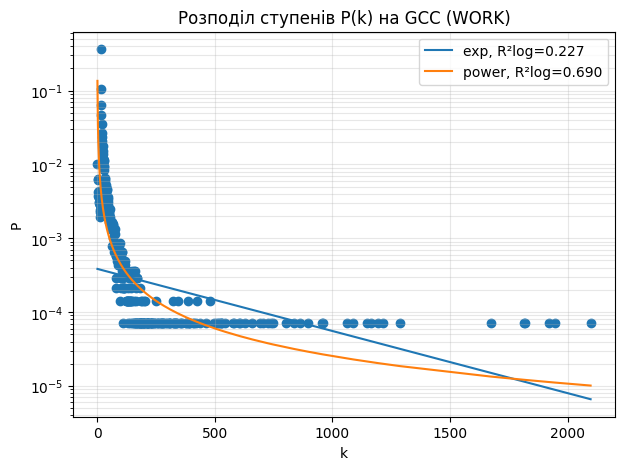

In [ ]:
K_SPARSE = 15
N = 14340

edges = build_knn_edges(path, N=N, k=K_SPARSE)
A_work = edges_to_csr(N, edges)

A_work_gcc, gcc_nodes, gcc_frac, comps = extract_gcc(A_work)
G_work = nx.from_scipy_sparse_array(A_work_gcc)

# Ступені у GCC
deg = np.diff(A_work_gcc.indptr).astype(int)

xk, pk = pmf_discrete(deg)

# Для фіту хвоста зазвичай беремо xmin не дуже малий
k_min = max(2, int(np.percentile(deg, 80)))  # просте правило: хвіст з 80-го перцентиля

fitk_exp = fit_exponential(xk, pk, xmin=k_min)
fitk_pow = fit_powerlaw(xk, pk, xmin=k_min)

print("P(k) fit (tail from k_min):", k_min)
print("  exponential:", fitk_exp)
print("  power-law  :", fitk_pow)

plot_fit_discrete(xk, pk, fitk_exp, fitk_pow,
                  title="Розподіл ступенів P(k) на GCC (WORK)",
                  xlabel="k")

Для хвоста (від $k_{\min}=27$) степенева (power-law) апроксимація краща за показникову:

  * $R^2_{\log}$ для exp ≈ 0.227 (погано)
  * $R^2_{\log}$ для power-law ≈ 0.690 (помітно краще)

У мережі є "хаби" - небагато вузлів (генів) з дуже великим ступенем $k$, і багато вузлів з малим (k). Це узгоджується з інтуїцією про біологічні/регуляторні мережі: є "центральні" гени/регулятори, які пов’язані з багатьма іншими, а більшість генів мають обмежене коло "найближчих" зв’язків.

У нас граф побудований через kNN, тому ми штучно гарантуємо мінімальну кількість зв’язків для кожного вузла (часто близько $k$), що може спотворювати низ розподілу, але хвіст (великі $k$) все одно показує наявність хабів, бо деякі вузли стають популярними сусідами для багатьох.

**P(C): розподіл локальної кластеризації та апроксимація**

1. Для кожної вершини $i$ з $k_i \ge 2$: $C_i=\frac{2T_i}{k_i(k_i-1)}$, де $T_i$ – кількість трикутників, що проходять через вершину $i$
2. Будуємо гістограму значень $C_i$ (бо $C$ неперервний у $[0,1]$), і нормуємо: $P(C \in [c, c+\Delta c])=\frac{{i: C_i \in [c, c+\Delta c]}}{N}$
3. Апроксимуємо хвіст для показникової і степенової форми (для ділянки $C \ge C_{min}$) і порівнюємо $R^2_{log}$

P(C) fit (tail from C_min): 0.02
  exponential: {'A': 0.07500089059145103, 'lambda': 4.27254740949089, 'r2_log': 0.7608661440364344, 'xmin': 0.02}
  power-law  : {'B': 0.0032129253289874763, 'gamma': 1.0521505326888312, 'r2_log': 0.40488386666790466, 'xmin': 0.02}


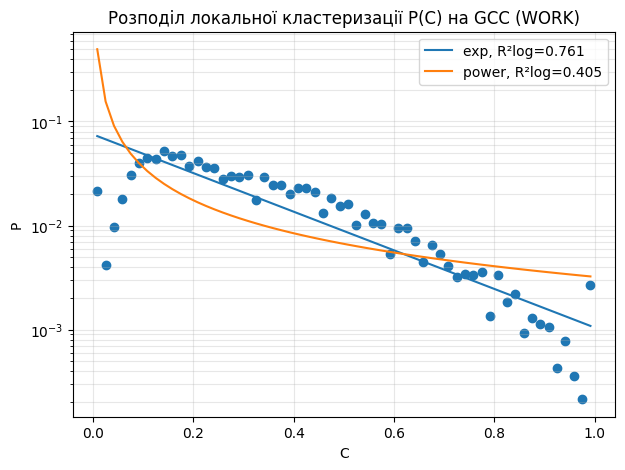

In [ ]:
def local_clustering_coeffs(A):
    # Точний локальний коефіцієнт кластеризації C_i для всіх вузлів, працює на бінарному ненапрямленому графі без діагоналі
    # Для вузла i, 2*T_i = sum_j (A^2 ⊙ A)_{ij}, тоді C_i = 2*T_i / (k_i*(k_i-1)) = row_sum / (k_i*(k_i-1))
    A_bin = A.copy()
    A_bin.data = np.ones_like(A_bin.data)
    A_bin.setdiag(0)
    A_bin.eliminate_zeros()

    deg = np.diff(A_bin.indptr).astype(float)

    A2 = A_bin @ A_bin
    B = A2.multiply(A_bin)
    row_sum = np.array(B.sum(axis=1)).reshape(-1)  # це 2*T_i

    denom = deg * (deg - 1.0)
    C = np.zeros_like(deg, dtype=float)
    mask = denom > 0
    C[mask] = row_sum[mask] / denom[mask]
    return C

C_i = local_clustering_coeffs(A_work_gcc)

xC, pC = pmf_hist(C_i, bins=60, range=(0.0, 1.0))

C_min = 0.02
fitC_exp = fit_exponential(xC, pC, xmin=C_min)
fitC_pow = fit_powerlaw(xC, pC, xmin=C_min)

print("P(C) fit (tail from C_min):", C_min)
print("  exponential:", fitC_exp)
print("  power-law  :", fitC_pow)

plot_fit_continuous(xC, pC, fitC_exp, fitC_pow,
                    title="Розподіл локальної кластеризації P(C) на GCC (WORK)",
                    xlabel="C")

Для хвоста від $C_{\min}=0.02$ показникова апроксимація краща:

  * exp $R^2_{\log}$ ≈ 0.761 (доволі добре)
  * power-law $R^2_{\log}$ ≈ 0.405 (гірше)

Значення локальної кластеризації $C_i$ (наскільки сусіди вузла з’єднані між собою) частіше спадають швидко, ближче до експоненційної поведінки. Це означає, що дуже високий $C_i$ трапляється, але рідко, і зростання "трикутності" має не настількив важкий хвіст, як у ступенів.

**P(l): розподіл довжин найкоротших шляхів**

1. Вибираємо набір джерел (не всі вершини для точного обрахунку через складність обчислень)
2. Запускаємо BFS (для незваженого графа) та збираємо відстані до інших вершин
3. Будуємо розподіл $P(l)=\frac{{(u,v): d(u,v)=l}}{\text{Pairs}}$, де $d(u,v)$ – довжина найкоротшого шляху

У нашій реалізації ми збираємо відстані для кожного джерела до всіх інших, тобто фактично працюємо з впорядкованими парами $(u,v)$, $u\neq v$.

Аналогічно фітимо хвіст $l \ge l_{min}$ двома моделями $P(l)\approx A e^{-\lambda l}, P(l)\approx B l^{-\gamma}$ та порівнюємо $R^2_{log}$.

BFS for P(l):   0%|          | 0/3000 [00:00<?, ?it/s]

P(l) computed with pairs: 42057000
P(l) fit (tail from l_min): 2
  exponential: {'A': 94.6300824558555, 'lambda': 1.9531424656824166, 'r2_log': 0.7196906577348878, 'xmin': 2}
  power-law  : {'B': 247.93742223762862, 'gamma': 6.863688541693331, 'r2_log': 0.5502346758267755, 'xmin': 2}


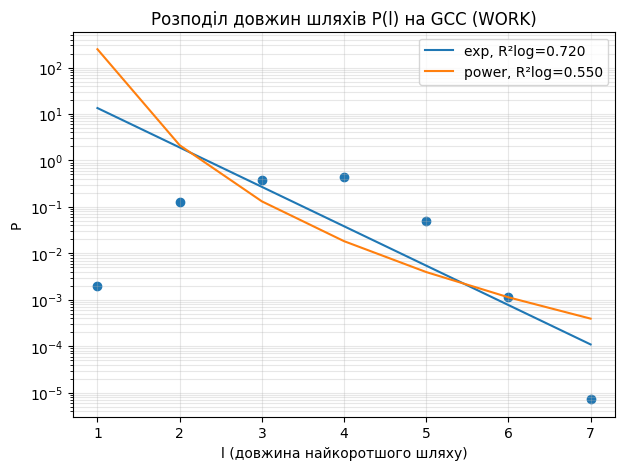

In [ ]:
def distance_histogram_unweighted(A_gcc, exact=True, n_sources=200, seed=0, show_progress=True):
    # Повертає (l_values, P(l)) для довжин найкоротших шляхів по впорядкованих парах (u,v), u!=v із максимумом n*(n-1)
    n = A_gcc.shape[0]
    indptr = A_gcc.indptr
    indices = A_gcc.indices

    rng = np.random.default_rng(seed)
    if exact:
        sources = np.arange(n, dtype=int)
    else:
        n_sources = min(int(n_sources), n)
        sources = rng.choice(n, size=n_sources, replace=False)

    hist = np.zeros(32, dtype=np.int64)
    total_pairs = 0

    it = sources
    if show_progress:
        it = tqdm(it, total=len(sources), desc="BFS for P(l)")

    for s in it:
        dist = np.full(n, -1, dtype=np.int32)
        dist[s] = 0
        q = deque([s])

        while q:
            v = q.popleft()
            start, end = indptr[v], indptr[v+1]
            for u in indices[start:end]:
                if dist[u] == -1:
                    dist[u] = dist[v] + 1
                    q.append(u)

        d = dist[dist > 0]  # без self=0
        if d.size == 0:
            continue

        total_pairs += int(d.size)
        dmax = int(d.max())
        if dmax >= len(hist):
            hist = np.pad(hist, (0, dmax - len(hist) + 1))

        counts = np.bincount(d, minlength=len(hist))
        hist[:len(counts)] += counts

    l_vals = np.nonzero(hist)[0]
    p = hist[l_vals] / total_pairs if total_pairs > 0 else hist[l_vals]
    return l_vals, p, int(total_pairs)

xl, pl, pairs_used = distance_histogram_unweighted(A_work_gcc, exact=False, n_sources=3000, seed=42)
print("P(l) computed with pairs:", pairs_used)

l_min = 2
fitl_exp = fit_exponential(xl, pl, xmin=l_min)
fitl_pow = fit_powerlaw(xl, pl, xmin=l_min)

print("P(l) fit (tail from l_min):", l_min)
print("  exponential:", fitl_exp)
print("  power-law  :", fitl_pow)

plot_fit_discrete(xl, pl, fitl_exp, fitl_pow,
                  title="Розподіл довжин шляхів P(l) на GCC (WORK)",
                  xlabel="l (довжина найкоротшого шляху)")

Розподіл найкоротших шляхів $P(l)$ на GCC має максимум на малих $l$ (переважно 2–4), а ймовірність великих відстаней (6–7) швидко спадає. Це свідчить про "компактність" мережі та наявність small-world властивості: між більшістю пар вузлів існують короткі шляхи, а довгі шляхи трапляються рідко.

Апроксимація хвоста показниковою функцією ($R^2_{\log}\approx 0.72$) описує дані краще за степеневу ($R^2_{\log}\approx 0.55$), що відповідає очікуваному швидкому спадові ймовірностей для великих відстаней. Степеневий закон частіше характерний для інших розподілів (наприклад, $P(k)$ у scale-free мережах), але не обов’язково для відстаней.

Зауваження: тут $l$ приймає дуже мало можливих значень (1-7), тому будь-яка апроксимація буде нестабільним.


**Кореляції: асортативність і залежності C(k), Centrality(k)**

In [ ]:
def edge_pearson_corr(G, x):
    # Кореляція Пірсона між значеннями x[u] та x[v] по ребрах
    if isinstance(x, dict):
        get = lambda u: x[u]
    else:
        x = np.asarray(x, dtype=float)
        get = lambda u: x[int(u)]

    xs = []
    ys = []
    for u, v in G.edges():
        xs.append(get(u))
        ys.append(get(v))

    xs = np.asarray(xs, dtype=float)
    ys = np.asarray(ys, dtype=float)

    if xs.size < 2:
        return np.nan
    return float(np.corrcoef(xs, ys)[0,1])

# degree assortativity
r_deg = nx.degree_assortativity_coefficient(G_work)
print("Degree assortativity r_k =", r_deg)

# асортативність по кластеризації
r_C = edge_pearson_corr(G_work, C_i)
print("Assortativity by C_i (corr on edges) =", r_C)

Degree assortativity r_k = -0.1278621217409109
Assortativity by C_i (corr on edges) = -0.285681122416236


Degree assortativity $r_k = -0.1279$

Це помірно негативне значення, отже, в розрідженому графі (kNN, $k=15$) хаби (вузли з великим $k$) частіше під’єднані до вузлів з малим ступенем, а не до інших хабів.

Assortativity by $C_i = -0.2857$

Є аналогом асортативності, але не по ступеню, а по локальному коефіцієнту кластеризації $C_i$ (наскільки "сусіди вузла теж з’єднані між собою"). Показує помірно сильну негативну кореляцію, тобто є локально щільні кластери (де багато трикутників), але вони з’єднані між собою через вузли, що виконують роль "місточків" (у них часто низька кластеризація, бо вони зв’язують різні частини мережі).


**C(k): середня кластеризація для вузлів з однаковим k**

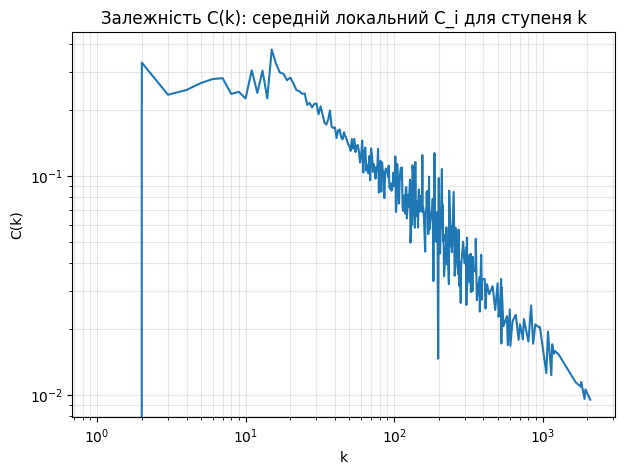

In [ ]:
def mean_by_degree(deg, values):
    # Для кожного k: середнє значення values серед вузлів зі ступенем k
    deg = np.asarray(deg, dtype=int)
    values = np.asarray(values, dtype=float)

    sums = defaultdict(float)
    cnts = defaultdict(int)

    for k, val in zip(deg, values):
        sums[int(k)] += float(val)
        cnts[int(k)] += 1

    ks = np.array(sorted(cnts.keys()))
    means = np.array([sums[k]/cnts[k] for k in ks])
    return ks, means, np.array([cnts[k] for k in ks])

ks, Ck, nk = mean_by_degree(deg, C_i)

plt.figure(figsize=(7,5))
plt.plot(ks, Ck)
plt.xscale("log")
plt.yscale("log")
plt.title("Залежність C(k): середній локальний C_i для ступеня k")
plt.xlabel("k")
plt.ylabel("C(k)")
plt.grid(True, which="both", alpha=0.3)
plt.show()

Явна тенденція: зі зростанням $k$ середній $C(k)$ зменшується (на лог-лог виглядає як спад).

Типові результати для реальних мереж:

* Вузли з малим $k$ частіше лежать у щільних модулях (групах), де всі між собою пов’язані → високий $C$
* Хаби (великий $k$) часто з’єднують різні групи між собою. Їхні сусіди зазвичай з різних кластерів і не з’єднані між собою → низький $C$

Це ознака ієрархічної/модульної структури: є локальні щільні групи + "містки" між ними.

**Centrality(k): як центральності залежать від k**

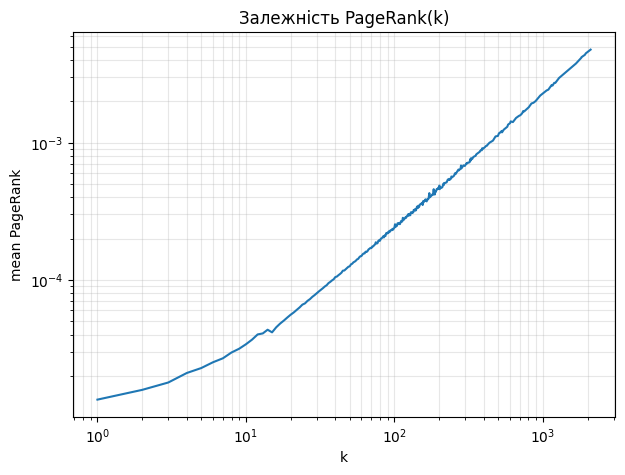

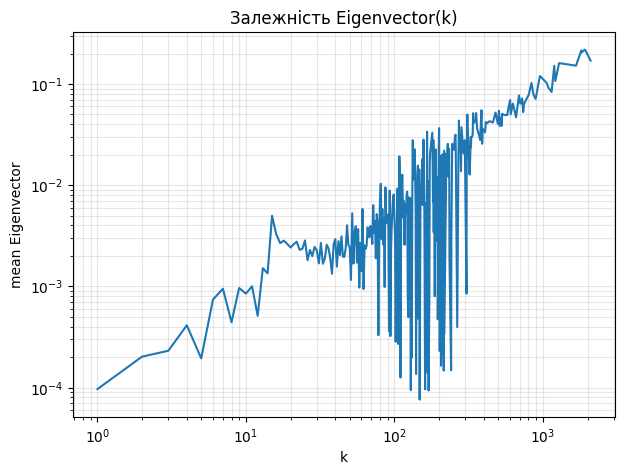

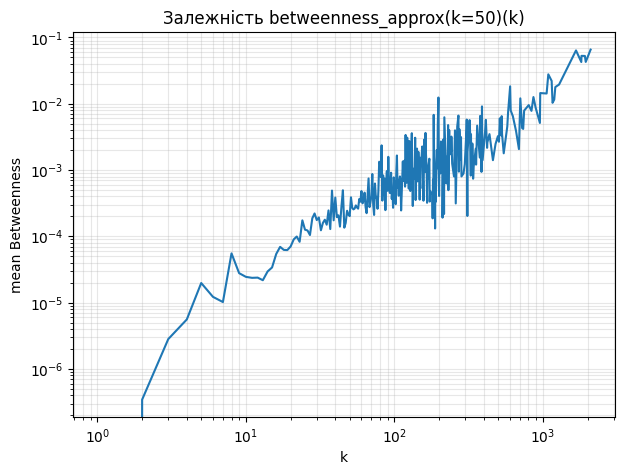

In [ ]:
cent_work = centralities_report(G_work, seed=42, betweenness_mode="approx", k_approx=50, closeness_mode="approx", closeness_sources=50)

def dict_to_array(d, n):
    arr = np.zeros(n, dtype=float)
    for node, val in d.items():
        arr[int(node)] = float(val)
    return arr

n_gcc = A_work_gcc.shape[0]

pr_arr = dict_to_array(cent_work["pagerank"], n_gcc)
ev_arr = dict_to_array(cent_work["eigenvector"], n_gcc)

btw_key = [k for k in cent_work.keys() if k.startswith("betweenness")][0]
btw_arr = dict_to_array(cent_work[btw_key], n_gcc)

ks, PRk, _ = mean_by_degree(deg, pr_arr)
ks, EVk, _ = mean_by_degree(deg, ev_arr)
ks, BTWk, _ = mean_by_degree(deg, btw_arr)

plt.figure(figsize=(7,5))
plt.plot(ks, PRk)
plt.xscale("log")
plt.yscale("log")
plt.title("Залежність PageRank(k)")
plt.xlabel("k")
plt.ylabel("mean PageRank")
plt.grid(True, which="both", alpha=0.3)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(ks, EVk)
plt.xscale("log")
plt.yscale("log")
plt.title("Залежність Eigenvector(k)")
plt.xlabel("k")
plt.ylabel("mean Eigenvector")
plt.grid(True, which="both", alpha=0.3)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(ks, BTWk)
plt.xscale("log")
plt.yscale("log")
plt.title(f"Залежність {btw_key}(k)")
plt.xlabel("k")
plt.ylabel("mean Betweenness")
plt.grid(True, which="both", alpha=0.3)
plt.show()

У середньому **Eigenvector**-centrality зростає з $k$, але є шум/нестабільність на середніх $k$. Показник високий у вузлів, які не просто мають багато зв’язків, а під’єднані до інших "впливових" вузлів. Хаби сидять у "ядрі" графа, пов’язані між собою або через густі зони. Шум усередині виникає, бо для кожного $k$ може бути небагато вузлів, і значення сильно різняться: частина вузлів з таким $k$ може бути в ядрі, частина — на периферії.

**PageRank** дуже гладко і майже монотонно росте та сильно корелює з $k$. Чим більше зв’язків, тим більше "стаціонарної ймовірності". Тобто PageRank тут в основному підтверджує, що високостепеневі вузли домінують як "центральні".

**Betweenness (approx)** в середньому також зростає з (k) та містить шум усередині, і показує все те ж саме, що частина хабів — "містки" між ділянками графа, важливі для зв’язності та передачі "впливу/сигналу" між модулями.

##  Підсумок

* $P(k)$ має хвіст, який краще описує **степенева** модель, ніж експоненційна → у мережі є **хаби**.
* $P(C)$ краще описується **експоненційною** апроксимацією → дуже великі $C$ трапляються рідко і "швидко зникають".
* $C(k)$ падає з ростом $k$ → **модульна структура**: дрібні вузли в щільних групах, хаби з’єднують групи.
* $P(l)$ ліпше апроксимується **степеневою** моделлю → між більшістю пар вузлів існують короткі шляхи, а довгі шляхи трапляються рідко.
* $Centrality(k)$ загалом зростає з $k$ (PageRank, eigenvector, betweenness) → хаби формують "ядро" і/або "містки".
* $Асортативність$ за ступенем $r_k<0$ і за кластеризацією $r_C<0$ → мережа **дисасортативна**, хаби тягнуться до периферії, а "щільні" вузли з’єднуються через "менш щільні" вузли-посередники.

# Практична робота: Частина 3

## Завдання
На робочому розрідженому графі проаналізувати виникнення структур (аналіз спільнот) та процесів(стійкість до випадкових і спрямованих атак, поширення)

**Допоміжні функції**

In [12]:
def gcc_fraction_nx(G):
    """Повертає (gcc_size, gcc_fraction_of_original_nodes)."""
    n = G.number_of_nodes()
    if n == 0:
        return 0, 0.0
    gcc = max(nx.connected_components(G), key=len)
    return len(gcc), len(gcc) / n


def community_to_labels(G, communities):
    """
    communities: iterable of sets of nodes
    -> labels dict: node -> community_id
    """
    labels = {}
    for cid, comm in enumerate(communities):
        for u in comm:
            labels[u] = cid
    # на всяк: якщо хтось не потрапив (не має бути), дамо окремий id
    missing = [u for u in G.nodes() if u not in labels]
    if missing:
        cid = max(labels.values(), default=-1) + 1
        for u in missing:
            labels[u] = cid
            cid += 1
    return labels


def summarize_communities(communities):
    sizes = np.array(sorted([len(c) for c in communities], reverse=True), dtype=int)
    return {
        "n_communities": int(len(sizes)),
        "sizes_top10": sizes[:10].tolist(),
        "min_size": int(sizes.min()) if sizes.size else 0,
        "median_size": float(np.median(sizes)) if sizes.size else 0.0,
        "max_size": int(sizes.max()) if sizes.size else 0,
    }


def plot_community_sizes(communities, title):
    sizes = sorted([len(c) for c in communities], reverse=True)
    plt.figure(figsize=(7,4))
    plt.plot(sizes)
    plt.title(title)
    plt.xlabel("community rank")
    plt.ylabel("size")
    plt.grid(True, alpha=0.3)
    plt.show()


def visualize_communities_sample(G, labels, sample_n=800, seed=0, title=""):
    rng = np.random.default_rng(seed)
    nodes = np.array(list(G.nodes()))
    sample_n = min(sample_n, len(nodes))
    sample = rng.choice(nodes, size=sample_n, replace=False)

    H = G.subgraph(sample).copy()
    # якщо раптом стало зовсім розірвано, можна взяти GCC(H)
    if H.number_of_nodes() > 0:
        gcc = max(nx.connected_components(H), key=len)
        H = H.subgraph(gcc).copy()

    pos = nx.spring_layout(H, seed=seed)
    c = [labels[u] for u in H.nodes()]

    plt.figure(figsize=(8, 6))
    nx.draw_networkx_edges(H, pos, width=0.4, alpha=0.35)
    nx.draw_networkx_nodes(H, pos, node_size=25, node_color=c, cmap="tab20")
    plt.title(title + f" (sample={H.number_of_nodes()}, edges={H.number_of_edges()})")
    plt.axis("off")
    plt.show()


def _safe_modularity(G, communities, weight=None):
    """Обгортка для забезпечення передачі списку list[set]."""
    comm_list = [set(c) for c in communities]
    return modularity(G, comm_list, weight=weight)


def _kl_bisection(G, seed=0, weight=None):
    """
    Kernighan–Lin 2-way bisection.  Повертає [setA, setB].
    """
    try:
        A, B = kernighan_lin_bisection(G, seed=seed, weight=weight)
    except TypeError:
        A, B = kernighan_lin_bisection(G, seed=seed)
    return [set(A), set(B)]


def _recursive_kl_bisection(G, target_k=16, seed=0, weight=None, min_size=50):
    """
    Рекурсивне бісекціонування: розділіть найбільшу частину, доки не досягнете target_k частин.
    Корисно для «бісекціонування» з більше ніж 2 спільнотами.
    """
    parts = [set(G.nodes())]

    while len(parts) < target_k:
        idx = int(np.argmax([len(p) for p in parts]))
        nodes = parts.pop(idx)

        if len(nodes) < 2 * min_size:
            parts.append(nodes)
            break

        H = G.subgraph(nodes).copy()
        split = _kl_bisection(H, seed=seed, weight=weight)

        if min(len(split[0]), len(split[1])) == 0:
            parts.append(nodes)
            break

        parts.extend(split)

    return parts


def _girvan_newman_best_partition(G, max_levels=6, weight=None):
    """
    Girvan–Newman повертає ієрархію розділів.
    Ми оцінимо перші `max_levels` і повернемо той, що має найкращу модульність.
    ПРИМІТКА: Дуже дорого на великих графах.
    """
    gen = girvan_newman(G)

    best_comm = None
    best_Q = -1.0

    for communities in itertools.islice(gen, max_levels):
        comm_list = [set(c) for c in communities]
        Q = _safe_modularity(G, comm_list, weight=weight)
        if Q > best_Q:
            best_Q = Q
            best_comm = comm_list

    return best_comm, float(best_Q)


def _louvain(G, seed=0, weight=None, resolution=1.0):
    """
    Louvain modularity оптимізація. Повертає list[set].
    """
    # networkx signature supports seed + resolution in most versions
    try:
        comm = louvain_communities(G, seed=seed, weight=weight, resolution=resolution)
    except TypeError:
        comm = louvain_communities(G, seed=seed, weight=weight)
    return [set(c) for c in comm]


def visualize_comm_result(G, comm_res, method_key, sample_n=1200, seed=42):
    main = comm_res[method_key]
    labels = community_to_labels(G, main["communities"])

    plot_community_sizes(main["communities"], title=f"Community sizes ({method_key}), Q={main['Q']:.3f}")
    visualize_communities_sample(
        G, labels, sample_n=sample_n, seed=seed, title=f"Communities on WORK GCC ({method_key})"
    )

## Виникнення структур: аналіз спільнот

**Мета:** знайти спільноти (community structure), оцінити їх розміри та "якість" (модульність), подивитися на структуру візуально.

**Кроки:**

1. Беремо робочий граф на GCC: (G).

2. Запускаємо алгоритми пошуку спільнот (без ваг) і порівнюємо їхню логіку:

   * `greedy_modularity_communities` (жадібна максимізація модульності)

     **Ідея:** ми хочемо розбити граф на групи так, щоб усередині спільнот було більше ребер, ніж очікується "випадково". Це вимірює модульність Q.

     **Як працює:** алгоритм стартує з дрібного розбиття (умовно: кожна вершина сама собі "спільнота") і далі жадібно об’єднує пари спільнот, які дають найбільший приріст Q. Об’єднання повторюються, доки Q більше суттєво не покращується.

     **Що це дає:** зазвичай отримуємо виразніші спільноти і вищу Q, але ціна більша обчислювальна складність, особливо на великих графах.

   * `label_propagation_communities` (поширення міток) – швидкий baseline

     **Ідея:** спільнота "виростає" з локальної узгодженості: вершина схильна належати до тієї ж групи, що й більшість її сусідів.

     **Як працює:** кожна вершина отримує мітку (на старті часто унікальну), а далі в ітераціях вершини оновлюють свою мітку на найпопулярнішу серед сусідів. Поступово великі області графа "узгоджуються" і формують спільноти.

     **Що це дає:** дуже швидко і добре як baseline, але результат може бути нестабільним (залежить від порядку оновлень/випадковості) і не обов’язково оптимізує Q так прямо, як greedy.

3. Рахуємо:

   * кількість спільнот,
   * розподіл розмірів спільнот,
   * modularity (Q) (для оцінки “якості” розбиття).

4. Візуалізуємо:

   * розподіл розмірів спільнот,
   * підграф із випадкової вибірки вершин, пофарбований за community id.


In [14]:
def run_community_analysis(G, seed=0):
    # greedy modularity
    print("\n[COMM] Running greedy_modularity_communities ...")
    comm_greedy = list(greedy_modularity_communities(G, weight=None))
    Q_greedy = modularity(G, comm_greedy, weight=None)
    sum_greedy = summarize_communities(comm_greedy)

    print(f"[COMM greedy] Q={Q_greedy:.4f}  n={sum_greedy['n_communities']}  "
          f"min={sum_greedy['min_size']}  med={sum_greedy['median_size']:.1f}  max={sum_greedy['max_size']}")

    # label propagation
    print("\n[COMM] Running label_propagation_communities ...")
    comm_lp = list(label_propagation_communities(G))
    Q_lp = modularity(G, comm_lp, weight=None)
    sum_lp = summarize_communities(comm_lp)

    print(f"[COMM label-prop] Q={Q_lp:.4f}  n={sum_lp['n_communities']}  "
          f"min={sum_lp['min_size']}  med={sum_lp['median_size']:.1f}  max={sum_lp['max_size']}")

    return {"greedy": {"communities": comm_greedy, "Q": float(Q_greedy), "summary": sum_greedy},
            "label_prop": {"communities": comm_lp, "Q": float(Q_lp), "summary": sum_lp}}

[WORK] k=15 N=14340 M=190332 <k>=26.55 kmax=2097 comps=320 GCC=0.978
[WORK GCC graph] nodes=14020 edges=190331

[COMM] Running greedy_modularity_communities ...
[COMM greedy] Q=0.4965  n=9  min=2  med=38.0  max=6508

[COMM] Running label_propagation_communities ...
[COMM label-prop] Q=0.6239  n=19  min=2  med=103.0  max=4456


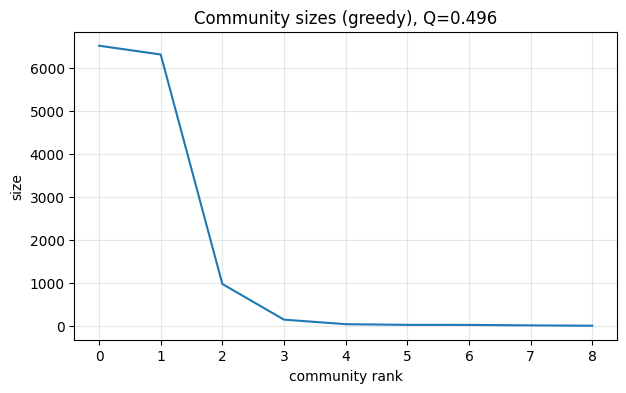

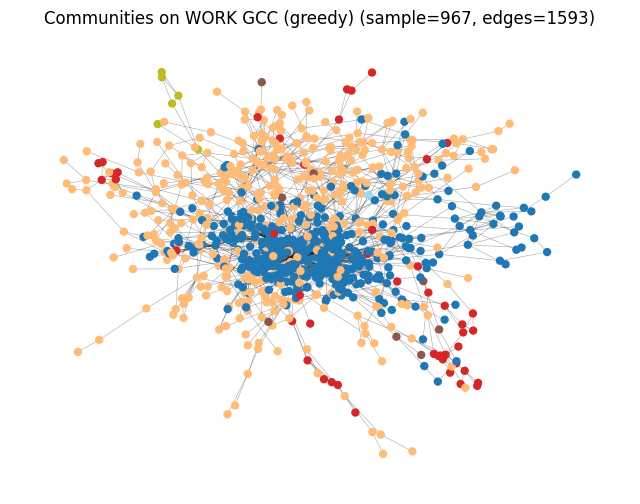

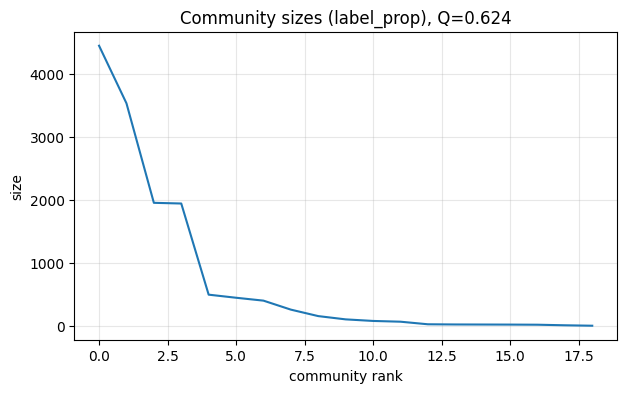

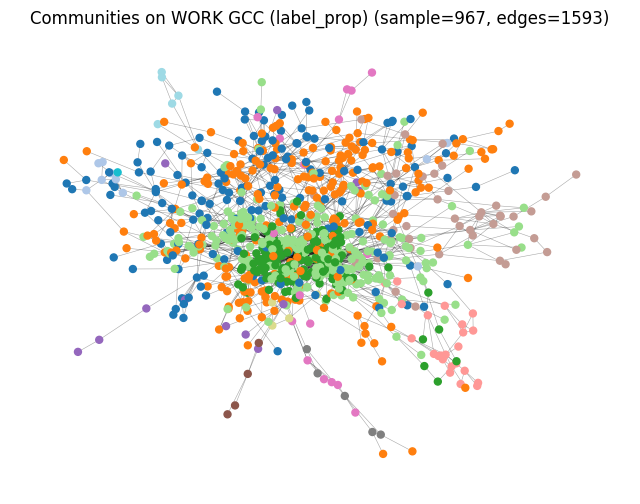

In [24]:
K_SPARSE = 15
N = 14340

edges = build_knn_edges(path, N=N, k=K_SPARSE)
A_work = edges_to_csr(N, edges)

A_work_gcc, gcc_nodes, gcc_frac, comps = extract_gcc(A_work)
s_work = basic_stats(A_work)

print(f"[WORK] k={K_SPARSE} N={s_work['N']} M={s_work['M']} <k>={s_work['<k>']:.2f} "
      f"kmax={s_work['kmax']} comps={comps} GCC={gcc_frac:.3f}")

G_work = nx.from_scipy_sparse_array(A_work_gcc)

print(f"[WORK GCC graph] nodes={G_work.number_of_nodes()} edges={G_work.number_of_edges()}")

# communities
comm_res = run_community_analysis(G_work, seed=42)

main = comm_res["greedy"]
labels = community_to_labels(G_work, main["communities"])

plot_community_sizes(main["communities"], title=f"Community sizes (greedy), Q={main['Q']:.3f}")
visualize_communities_sample(G_work, labels, sample_n=1200, seed=42, title="Communities on WORK GCC (greedy)")

main = comm_res["label_prop"]
labels = community_to_labels(G_work, main["communities"])

plot_community_sizes(main["communities"], title=f"Community sizes (label_prop), Q={main['Q']:.3f}")
visualize_communities_sample(G_work, labels, sample_n=1200, seed=42, title="Communities on WORK GCC (label_prop)")

Базова структура графа (WORK, k=15) показує, що граф усе ще досить щільний *як для розрідженого* (в середньому ~26–27 сусідів на вузол), що логічно для kNN-ідеї (зв’язки "за схожістю"), дуже великий максимум степеня $kmax=2097$ означає наявність суперхабів, більше того майже всі вершини лежать в одній гігантській компоненті. Мережа має достатньо "мостів/хабів", щоб швидко з’єднувати віддалені області, що видно з середньої відстаня між двома випадковими вершинами в GCC ~3–4 ребра.

Це спонукає висунути гіпотези про наявність великих яскраво виражених спільнот, що підтверджується результатами обох методів *greedy_modularity_communities* (максимізація модульності) $Q≈0.496$ та *label_propagation_communities* (швидкий baseline) $Q≈0.624$. Такі значення $Q$ означають, що в графі є сильна модульна структура: ребер всередині груп значно більше, ніж очікувалося б у "випадковому" аналозі з подібною щільністю.

* *greedy_modularity* $Q≈0.496$ знайшов 9 спільнот, 2 найбільші дуже домінують $max = 6508$, медіана розміру мала $med = 38$
* *label_propagation* знайшов 19 спільнот, при цьому:
  * модульність вища $Q≈0.624$
  * найбільша спільнота менша $max = 4456$
  * медіана більша $med = 103$

*label propagation* "дробить" структуру детальніше (більше спільнот), часто піднімаючи $Q$, але розбиття може бути менш стабільним. *Greedy* дає більш грубе, "макрорівневе" групування.

За графіком sizes видно кілька великих спільнот і довгий хвіст малих. Це типовий патерн для графів схожості: є велике ядро (або кілька "тем/кластерів") плюс маленькі спеціалізовані групи та периферія.

Візуалізація підграфа підтверджує групування. На випадковій вибірці вузлів (підграф) вузли з однаковим community id здебільшого формують локально щільні ділянки. При цьому видно "містки" між кольорами, що узгоджується з реальною мережею: спільноти не ізольовані повністю, між ними є зв’язки через хаби/перехідні вузли.



In [14]:
def run_community_analysis(G, seed=0, weight=None,
                           do_bisection=True,
                           recursive_bisection_k=0,
                           do_louvain=True,
                           louvain_resolution=1.0,
                           do_girvan_newman=False,
                           gn_max_levels=6):
    """
    Runs multiple community detection methods once and returns a unified dict.
    All methods are evaluated with the same modularity() call (weight can be None or "weight").
    """
    results = {}

    # bisection
    if do_bisection:
        print("\n[COMM] Kernighan–Lin bisection ...")
        if recursive_bisection_k and recursive_bisection_k > 2:
            comm_bis = _recursive_kl_bisection(
                G, target_k=int(recursive_bisection_k), seed=seed, weight=weight, min_size=50
            )
            Q_bis = _safe_modularity(G, comm_bis, weight=weight)
            results["bisection_recursive"] = {
                "communities": comm_bis,
                "Q": float(Q_bis),
                "summary": summarize_communities(comm_bis),
            }
            print(f"[COMM bisection_recursive] Q={Q_bis:.4f}  summary={results['bisection_recursive']['summary']}")
        else:
            comm_bis2 = _kl_bisection(G, seed=seed, weight=weight)
            Q_bis2 = _safe_modularity(G, comm_bis2, weight=weight)
            results["bisection_2"] = {
                "communities": comm_bis2,
                "Q": float(Q_bis2),
                "summary": summarize_communities(comm_bis2),
            }
            print(f"[COMM bisection_2] Q={Q_bis2:.4f}  summary={results['bisection_2']['summary']}")

    # Louvain
    if do_louvain:
        print("\n[COMM] Louvain ...")
        comm_lv = _louvain(G, seed=seed, weight=weight, resolution=float(louvain_resolution))
        Q_lv = _safe_modularity(G, comm_lv, weight=weight)
        results["louvain"] = {
            "communities": comm_lv,
            "Q": float(Q_lv),
            "summary": summarize_communities(comm_lv),
        }
        print(f"[COMM louvain] Q={Q_lv:.4f}  summary={results['louvain']['summary']}")

    # Girvan–Newman (expensive)
    if do_girvan_newman:
        print("\n[COMM] Girvan–Newman (expensive) ...")
        comm_gn, Q_gn = _girvan_newman_best_partition(G, max_levels=int(gn_max_levels), weight=weight)
        results["girvan_newman"] = {
            "communities": comm_gn,
            "Q": float(Q_gn),
            "summary": summarize_communities(comm_gn),
        }
        print(f"[COMM girvan_newman] Q={Q_gn:.4f}  summary={results['girvan_newman']['summary']}")

    return results

###Додаткові методи пошуку спільнот: бісекція, Louvain, Girvan–Newman

Після двох базових підходів (greedy modularity та label propagation) доречно додати ще три “класичні” алгоритми, які часто згадують у курсі як альтернативи. Вони відрізняються тим, **яку саме математичну ціль оптимізують** і **наскільки добре масштабуються на великі графи**.

**1) Бісекція (Kernighan–Lin)**

**Ідея.** Алгоритм ділить множину вершин на дві частини так, щоб **мінімізувати кількість ребер між частинами** (тобто мінімізувати *cut*). Це не оптимізація модульності, а задача "найкращого розрізу" для збалансованого поділу.

Оскільки бісекція дає лише 2 частини, ми запускаємо її **рекурсивно**, отримуючи 8–16 груп (послідовно розбиваючи найбільший кластер). Такий підхід зручний для отримання “грубого ієрархічного” поділу.

Для kNN-графа схожості бісекція добре виявляє великі блоки з мінімальною кількістю мостів між ними. Але її результат не завжди збігається з природними біологічними модулями, бо критерій cut може віддавати перевагу майже рівним за розміром розбиттям.

**2) Louvain (оптимізація модульності)**

**Ідея.** Louvain, як і greedy modularity, орієнтується на **максимізацію модульності $Q$**, але робить це у два рівні: (1) локальні переміщення вершин між спільнотами для зростання $Q$, (2) агрегація спільнот у мета-вузли та повторення процесу. Це дає дуже хороший баланс якості і швидкості на великих графах.

При $N \approx 14k$ та $M \approx 190k$ Louvain зазвичай є одним з найкращих практичних варіантів, бо:

* оптимізує ту саму інтуїтивну мету ($Q$), що і greedy,
* краще масштабується,
* має параметр `resolution`, який дозволяє контролювати масштаб спільнот (більш дрібні чи більш крупні).

**3) Girvan–Newman (видалення "містків")**

**Ідея.** Girvan–Newman будує ієрархію спільнот, **видаляючи ребра з найбільшою edge betweenness centrality**, тобто ребра, які найчастіше лежать на найкоротших шляхах і працюють як “містки” між частинами графа.

Обчислення edge betweenness є дорогим, тому Girvan–Newman погано масштабується.



**Який метод найбільше підходить нашій мережі:**
* Якщо мета якісні спільноти на повному графі і гарний компроміс швидкість/якість, то найкращий практичний вибір: Louvain (плюс порівняння з greedy і label propagation).
* Якщо мета ієрархічне грубе розбиття на великі блоки, де важливо мінімізувати “перетин” між частинами, доречна рекурсивна бісекція.
* Якщо мета: показати механізм "містків" і мати інтерпретовану демонстрацію, можна додати Girvan–Newman, але лише на семплі через обчислювальну вартість.


[WORK] k=15 N=14340 M=190332 <k>=26.55 kmax=2097 comps=320 GCC=0.978
[WORK GCC graph] nodes=14020 edges=190331

[COMM] Kernighan–Lin bisection ...
[COMM bisection_recursive] Q=0.5298  summary={'n_communities': 16, 'sizes_top10': [877, 877, 877, 877, 876, 876, 876, 876, 876, 876], 'min_size': 876, 'median_size': 876.0, 'max_size': 877}

[COMM] Louvain ...
[COMM louvain] Q=0.6401  summary={'n_communities': 12, 'sizes_top10': [3107, 2773, 2334, 1514, 1496, 983, 615, 593, 322, 222], 'min_size': 24, 'median_size': 799.0, 'max_size': 3107}


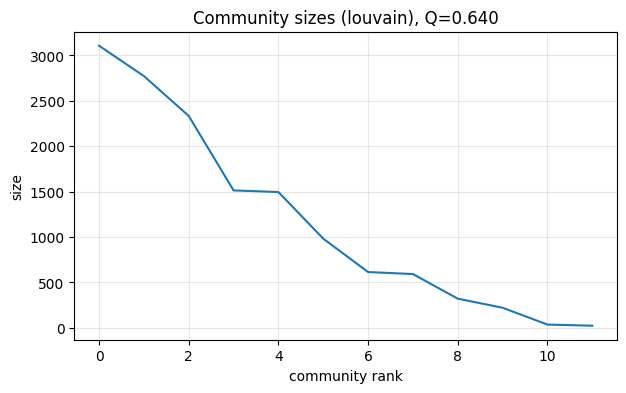

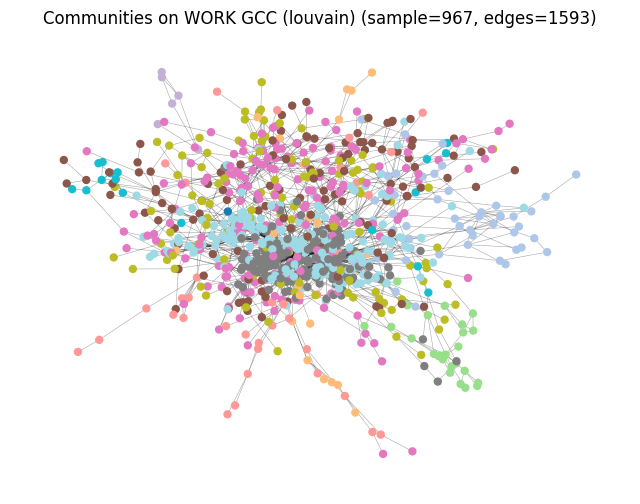

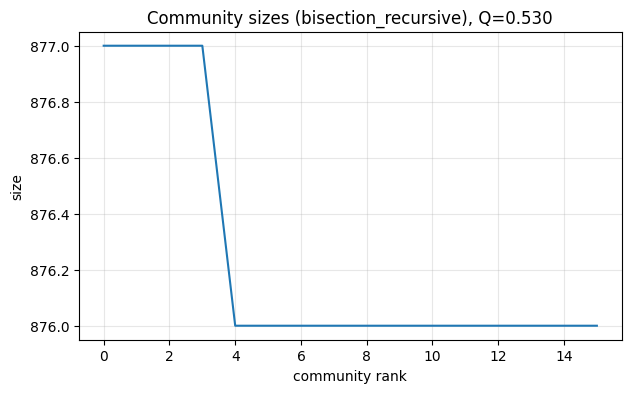

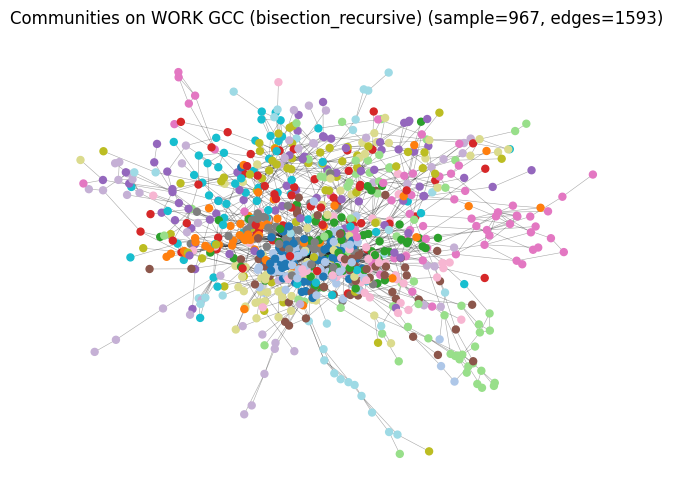

In [16]:
K_SPARSE = 15
N = 14340

edges = build_knn_edges(path, N=N, k=K_SPARSE)
A_work = edges_to_csr(N, edges)

A_work_gcc, gcc_nodes, gcc_frac, comps = extract_gcc(A_work)
s_work = basic_stats(A_work)

print(f"[WORK] k={K_SPARSE} N={s_work['N']} M={s_work['M']} <k>={s_work['<k>']:.2f} "
      f"kmax={s_work['kmax']} comps={comps} GCC={gcc_frac:.3f}")

G_work = nx.from_scipy_sparse_array(A_work_gcc)

print(f"[WORK GCC graph] nodes={G_work.number_of_nodes()} edges={G_work.number_of_edges()}")

comm_res = run_community_analysis(
    G_work,
    seed=42,
    weight=None,
    do_bisection=True,
    recursive_bisection_k=16,    # 0 or 2 => 2-way bisection; 8/16 => recursive bisection
    do_louvain=True,
    louvain_resolution=1.0,
    do_girvan_newman=False,
    gn_max_levels=6
)

for key in ["greedy", "label_prop", "louvain", "bisection_recursive"]:
    if key in comm_res:
        visualize_comm_result(G_work, comm_res, key, sample_n=1200, seed=42)

# # OPTIONAL: прогнати Girvan–Newman на маленькому підграфі
# def build_sample_gcc(G, sample_n=2500, seed=42):
#     rng = np.random.default_rng(seed)
#     nodes = np.array(list(G.nodes()))
#     sample = rng.choice(nodes, size=min(sample_n, len(nodes)), replace=False)
#     H = G.subgraph(sample).copy()
#     if H.number_of_nodes() > 0:
#         gcc = max(nx.connected_components(H), key=len)
#         H = H.subgraph(gcc).copy()
#     return H

# H_gn = build_sample_gcc(G_work, sample_n=2500, seed=42)
# comm_res_gn = run_community_analysis(
#     H_gn,
#     seed=42,
#     weight=None,
#     do_bisection=False,
#     do_louvain=False,
#     do_girvan_newman=True,
#     gn_max_levels=6,
# )
# visualize_comm_result(H_gn, comm_res_gn, "girvan_newman", sample_n=1200, seed=42)

## Процеси в мережі

#### A) Стійкість до атак (robustness)

**Мета:** дослідити як швидко "розвалюється" зв’язність (GCC fraction) при видаленні вузлів.

**Стратегії:**

* Випадкова атака: прибираємо випадкові вузли
* Спрямована атака: прибираємо вузли з найбільшим степенем

  * "Static" (сортуємо за початковим степенем один раз)
  * "Adaptive" (перераховуємо степені періодично)

**Метрика:** $S(f) = \frac{|GCC(f)|}{N_0}$, де $f$ – частка видалених вузлів, $N_0$ – початкове число вузлів у GCC

#### B) Поширення (spreading)

**Мета:** змоделювати, як процес (наприклад, епідемія) розповсюджується по мережі

Беремо **SIR** (Susceptible-Infected-Recovered) у дискретному часі:
* зараження з ймовірністю $\beta$ по ребру
* одужання з ймовірністю $\gamma$ за крок

Фікусуємо:

* peak infected (максимум інфікованих)
* фінальний розмір спалаху (частка recovered)
* час до піку


In [18]:
# Стійкість до атак (robustness)
def simulate_node_removal(G0, fracs, mode="random", seed=0, adaptive=False, batch=200):
    """
    mode: "random" | "degree"
    adaptive: якщо True і mode="degree", перераховуємо степені кожен batch
    Повертає список (f, S(f)) де S(f)=|GCC|/N0
    """
    rng = np.random.default_rng(seed)
    N0 = G0.number_of_nodes()
    nodes_all = np.array(list(G0.nodes()))

    G = G0.copy()
    removed = set()
    out = []

    # для static degree
    if mode == "degree" and not adaptive:
        deg = dict(G.degree())
        order = [u for u, _ in sorted(deg.items(), key=lambda x: x[1], reverse=True)]

    for f in fracs:
        target_remove = int(round(f * N0))
        need = target_remove - len(removed)
        if need <= 0:
            gcc_size = max((len(c) for c in nx.connected_components(G)), default=0)
            out.append((f, gcc_size / N0))
            continue

        while need > 0 and G.number_of_nodes() > 0:
            take = min(batch, need)

            if mode == "random":
                candidates = [u for u in nodes_all if u not in removed]
                pick = rng.choice(candidates, size=take, replace=False).tolist()

            elif mode == "degree":
                if adaptive:
                    deg = dict(G.degree())
                    # беремо top take по поточному графу
                    pick = [u for u, _ in sorted(deg.items(), key=lambda x: x[1], reverse=True)[:take]]
                else:
                    # беремо з попереднього order
                    pick = []
                    for u in order:
                        if u not in removed:
                            pick.append(u)
                            if len(pick) == take:
                                break
            else:
                raise ValueError("mode must be 'random' or 'degree'")

            G.remove_nodes_from(pick)
            removed.update(pick)
            need -= len(pick)

        gcc_size = max((len(c) for c in nx.connected_components(G)), default=0)
        out.append((f, gcc_size / N0))

    return out


def plot_robustness(curves, title="Robustness: GCC fraction under attacks"):
    plt.figure(figsize=(7,5))
    for name, data in curves.items():
        xs = [f for f, s in data]
        ys = [s for f, s in data]
        plt.plot(xs, ys, label=name)
    plt.title(title)
    plt.xlabel("fraction of removed nodes f")
    plt.ylabel("S(f) = |GCC| / N0")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


# Поширення (spreading)
def sir_simulate(G, beta=0.03, gamma=0.01, seed=0, initial_infected=1, t_max=200):
    """
    Discrete-time SIR on unweighted graph.
    Returns time series: S, I, R counts
    """
    rng = np.random.default_rng(seed)
    nodes = list(G.nodes())
    n = len(nodes)
    if n == 0:
        return {"S": [], "I": [], "R": []}

    # states: 0=S, 1=I, 2=R
    state = {u: 0 for u in nodes}
    init = rng.choice(nodes, size=min(initial_infected, n), replace=False)
    for u in init:
        state[u] = 1

    S_hist, I_hist, R_hist = [], [], []

    for _ in range(t_max):
        infected = [u for u in nodes if state[u] == 1]
        if not infected:
            break

        # infection attempts
        newly_infected = []
        for u in infected:
            for v in G.neighbors(u):
                if state[v] == 0 and rng.random() < beta:
                    newly_infected.append(v)

        # recovery
        newly_recovered = []
        for u in infected:
            if rng.random() < gamma:
                newly_recovered.append(u)

        for v in newly_infected:
            state[v] = 1
        for u in newly_recovered:
            state[u] = 2

        s = sum(1 for u in nodes if state[u] == 0)
        i = sum(1 for u in nodes if state[u] == 1)
        r = sum(1 for u in nodes if state[u] == 2)

        S_hist.append(s)
        I_hist.append(i)
        R_hist.append(r)

    return {"S": S_hist, "I": I_hist, "R": R_hist}


def sir_experiment(G, beta, gamma, runs=20, seed=0, initial_infected=1, t_max=200):
    rng = np.random.default_rng(seed)
    peaks = []
    finals = []
    tpeaks = []
    for _ in range(runs):
        s = int(rng.integers(0, 10**9))
        hist = sir_simulate(G, beta=beta, gamma=gamma, seed=s, initial_infected=initial_infected, t_max=t_max)
        I = np.array(hist["I"], dtype=int)
        R = np.array(hist["R"], dtype=int)
        if I.size == 0:
            peaks.append(0)
            finals.append(0)
            tpeaks.append(0)
        else:
            peaks.append(int(I.max()))
            tpeaks.append(int(I.argmax()))
            finals.append(int(R[-1]))
    n = G.number_of_nodes()
    return {"beta": beta,
            "gamma": gamma,
            "peak_I_frac_mean": float(np.mean(peaks) / n) if n else 0.0,
            "final_R_frac_mean": float(np.mean(finals) / n) if n else 0.0,
            "t_peak_mean": float(np.mean(tpeaks)) if len(tpeaks) else 0.0}

[ROBUST] random attack ...
[ROBUST] targeted degree (static) ...
[ROBUST] targeted degree (adaptive) ...


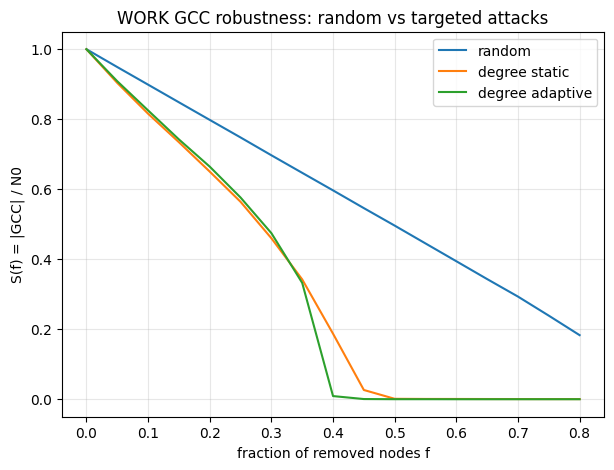


[SIR] Running small grid of beta ...
{'beta': 0.01, 'gamma': 0.01, 'peak_I_frac_mean': 0.776925820256776, 'final_R_frac_mean': 0.8096861626248216, 't_peak_mean': 44.15}
{'beta': 0.02, 'gamma': 0.01, 'peak_I_frac_mean': 0.8572646219686163, 'final_R_frac_mean': 0.8379457917261056, 't_peak_mean': 24.8}
{'beta': 0.03, 'gamma': 0.01, 'peak_I_frac_mean': 0.8903530670470756, 'final_R_frac_mean': 0.8449358059914408, 't_peak_mean': 18.5}
{'beta': 0.05, 'gamma': 0.01, 'peak_I_frac_mean': 0.9214728958630527, 'final_R_frac_mean': 0.8518865905848788, 't_peak_mean': 12.75}


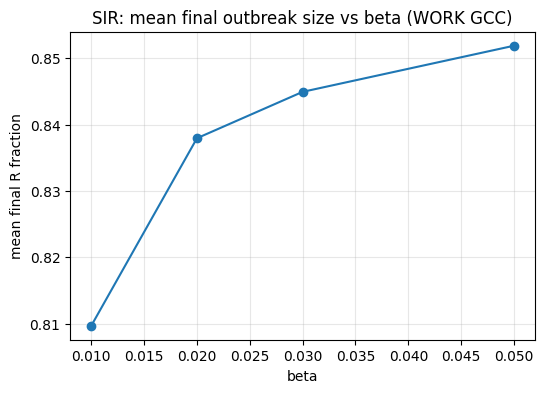

In [20]:
# robustness
fracs = np.linspace(0.0, 0.8, 17) # 0..0.8 step 0.05

print("[ROBUST] random attack ...")
rnd_curve = simulate_node_removal(G_work, fracs, mode="random", seed=42, batch=300)

print("[ROBUST] targeted degree (static) ...")
deg_static = simulate_node_removal(G_work, fracs, mode="degree", seed=42, adaptive=False, batch=300)

print("[ROBUST] targeted degree (adaptive) ...")
deg_adapt = simulate_node_removal(G_work, fracs, mode="degree", seed=42, adaptive=True, batch=200)

plot_robustness(
    {"random": rnd_curve, "degree static": deg_static, "degree adaptive": deg_adapt},
    title="WORK GCC robustness: random vs targeted attacks"
)

# spreading (SIR)
print("\n[SIR] Running small grid of beta ...")
betas = [0.01, 0.02, 0.03, 0.05]
gamma = 0.01
sir_rows = []
for b in betas:
    row = sir_experiment(G_work, beta=b, gamma=gamma, runs=20, seed=42, initial_infected=3, t_max=200)
    sir_rows.append(row)
    print(row)

plt.figure(figsize=(6,4))
plt.plot([r["beta"] for r in sir_rows], [r["final_R_frac_mean"] for r in sir_rows], marker="o")
plt.title("SIR: mean final outbreak size vs beta (WORK GCC)")
plt.xlabel("beta")
plt.ylabel("mean final R fraction")
plt.grid(True, alpha=0.3)
plt.show()

**1) Стійкість до випадкових і спрямованих атак (robustness)**

На графіку:
* Вісь $x$: частка видалених вершин $f$
* Вісь $y$: $S(f)=|GCC(f)|/N_0$ – частка вершин, які залишаються в гігантській компоненті зв’язності після видалення

Є три криві:

* *random* – випадкове видалення вершин
* *degree static* – видаляємо вершини у порядку спадання degree, але порядок фіксований з початку
* *degree adaptive* – після кожного кроку degree перераховується і знову видаляється поточний "хаб"

*Випадкова атака (random) "падає" повільно і майже лінійно*: навіть при $f \approx 0.8$ ще лишається помітна GCC $~0.18$. Це класичний ефект для мереж з хабами: якщо видаляти випадково, часто "промахуємось" повз найбільш зв’язні вузли, і ядро мережі ще довго тримається.

*Спрямовані атаки по degree руйнують мережу різко*. Вже десь біля $f \approx 0.35-0.45$ видно "колапс" GCC до майже нуля. *adaptive* падає трохи швидше/жорсткіше, ніж *static*, що очікувано, бо після видалення хабів "нові хаби" з’являються, і adaptive одразу їх добиває.

Мережа робастна до випадкових відмов, але вразлива до цілеспрямованого видалення хабів. Це узгоджується з тим, що у мережі дуже великий $k_{\max}=2097$ (хаби) і "важкий хвіст" у $P(k)$, тобто хаби формують "каркас" зв’язності.


**2) Поширення: модель SIR на WORK GCC**

* $\beta$ – інтенсивність "зараження" (ймовірність/швидкість передачі по ребру)
* $\gamma$ – "одужання/вилучення" (фіксовано $\gamma=0.01$)
* *peak_I_frac_mean* – середня максимальна частка інфікованих у піку
* *final_R_frac_mean* – середня частка вузлів, що зрештою побували інфікованими (кінцевий розмір спалаху)
* *t_peak_mean* – середній час до піку

Для $\gamma=0.01$ і росту $\beta$:

* *final_R_frac_mean* зростає приблизно з $0.81 → 0.85$
* *peak_I_frac_mean* зростає $≈0.78 → ≈0.92$
* *t_peak_mean* різко зменшується $~44 → ~13$

Спалах дуже "масовий" уже при малих $\beta$, навіть при $\beta=0.01$ фінально заражається $~81%$ вузлів GCC. Це ознака, що мережа добре зв’язана і має короткі шляхи ($\langle l\rangle \approx 3.41$), тому інфекція легко знаходить маршрути.

Збільшення $\beta$ робить процес швидшим (менше $t_{\text{peak}}$) та агресивнішим (вищий пік інфікованих), але кінцевий розмір спалаху зростає не драматично $0.81→0.85$, бо мережа й так уже майже "в зоні великого спалаху".
Інтуїтивно структура дозволяє дістатись багатьох вузлів навіть при низькій передачі; підняття $\beta$ в основному "ущільнює" час і пікове навантаження.

У такій мережі процеси поширення мають тенденцію швидко ставати глобальними на GCC, бути чутливими до хабів (це випливає і з robustness-графіка): контроль/захист хабів топ-degree вузлів повинні різко зменшувати масштаб спалаху і/або зсувати його поріг.
